# Zeel Patel
# Big Data & Cloud Computing Final Project
## Will Turing Bots replace Humans Software Developers?

### Step 1: Initializing Spark Session and Loading Full Data
- Importing necessary libraries for PySpark.
- Initializing a Spark session to process the full dataset.
- Defining the paths for all 5 folders (`commits`, `contents`, `files`, `languages`, `licenses`).
- Loading the full data from all 5 folders for processing.


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Step 1: Initializing the Spark session
spark = SparkSession.builder \
    .appName("GitHub Dataset Exploration - Full Data") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

spark.conf.set("spark.sql.debug.maxToStringFields", "1000")  # Set to 1000 or a larger value

# Step 2: Defining folder paths
base_path = "gs://msca-bdp-data-open/final_project_git"
folders = {
    "commits": f"{base_path}/commits",
    "contents": f"{base_path}/contents",
    "files": f"{base_path}/files",
    "languages": f"{base_path}/languages",
    "licenses": f"{base_path}/licenses"
}

# Step 3: Loading full data from each folder
full_data = {}
for folder_name, folder_path in folders.items():
    print(f"Loading full data from {folder_name}...")
    full_data[folder_name] = spark.read.parquet(folder_path)

# Step 4: Displaying the schema and sample data for each folder
for folder_name, df in full_data.items():
    print(f"\nSchema for {folder_name}:")
    df.printSchema()
    print(f"\nSample data from {folder_name}:")
    df.show(5, truncate=False)


Loading full data from commits...
Loading full data from contents...
Loading full data from files...
Loading full data from languages...
Loading full data from licenses...

Schema for commits:
root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- parent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- committer: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 | 

+----------------------------------------+----------------------------------------+------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------------+------------------------------------------------------------------------+--------+
|commit                                  |tree                                    |parent      

+----------------------------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+--------------------------------------+-----------------+----------------------------------------+-----+----------------------------------------+--------------+
|repo_name                             |ref              |path                                    |mode |id                                      |symlink_target|
+--------------------------------------+-----------------+----------------------------------------+-----+----------------------------------------+--------------+
|enzbang/diouzhtu                      |refs/heads/master|gwiad_wiki_service/scripts/do-install.sh|33261|49365044eed28769152726537f00a93a68988b07|null          |
|TheMrNomis/Latex-Flavored-Markdown-PHP|refs/heads/master|LFM.php                                 |33261|ef8cb78feed7f21115462b2e230c453ab1b9565a|null          |
|TheMrNomis/Latex-Flavored-Markdown-PHP|refs/heads/master|PHP/LatexFlavoredMarkdown.php           |33261|d989ce59652f57efaad0f73987977dcf088c0041|null          |
|xurigan/uexJPush           

+-------------------+------------+
|repo_name          |language    |
+-------------------+------------+
|lemi136/puntovent  |[{C, 80}]   |
|taxigps/nctool     |[{C, 4461}] |
|ahy1/strbuf        |[{C, 5573}] |
|nleiten/mod_rpaf-ng|[{C, 30330}]|
|kmcallister/alameda|[{C, 17077}]|
+-------------------+------------+
only showing top 5 rows


Schema for licenses:
root
 |-- repo_name: string (nullable = true)
 |-- license: string (nullable = true)


Sample data from licenses:
+-------------------------------------------------+------------+
|repo_name                                        |license     |
+-------------------------------------------------+------------+
|autarch/Dist-Zilla-Plugin-Test-TidyAll           |artistic-2.0|
|thundergnat/Prime-Factor                         |artistic-2.0|
|kusha-b-k/Turabian_Engin_Fan                     |artistic-2.0|
|onlinepremiumoutlet/onlinepremiumoutlet.github.io|artistic-2.0|
|huangyuanlove/LiaoBa_Service                     |artistic-2.0|
+---

### Step 2: Data Cleaning

### Step 2.1: Cleaning the `commits` Dataset
- Filtering rows to ensure:
  - `commit`, `author.name`, `author.email`, and `subject` are not null.
  - `repo_name` exists and is not empty.
- Selecting the following relevant fields:
  - `commit`, `author_name`, `author_email`, `author_time_sec`, `committer_name`, `committer_email`, `subject`, `message`, `repo_name`.
- Flattening the `repo_name` array for easier analysis.
- Ensuring consistency by matching `author.name` and `committer.name`.
- Removing duplicate rows based on critical fields (`commit` and `repo_name`).
- Finalizing the cleaned dataset for analysis.


In [10]:
from pyspark.sql import functions as F

# Step 1: Extracting the full commits DataFrame
commits_df = full_data["commits"]

# Step 2: Filtering rows with null or empty critical fields
commits_cleaned = commits_df.filter(
    F.col("commit").isNotNull() & 
    F.col("author.name").isNotNull() & 
    F.col("author.email").isNotNull() & 
    F.col("subject").isNotNull() & 
    F.col("repo_name").isNotNull()
).filter(
    F.size(F.col("repo_name")) > 0
)

# Step 3: Selecting relevant fields for analysis
commits_cleaned = commits_cleaned.select(
    "commit",
    F.col("author.name").alias("author_name"),
    F.col("author.email").alias("author_email"),
    F.col("author.time_sec").alias("author_time_sec"),
    F.col("committer.name").alias("committer_name"),
    F.col("committer.email").alias("committer_email"),
    "subject",
    "message",
    F.explode(F.col("repo_name")).alias("repo_name")  # Flattening repo_name array
)

# Step 4: Filtering rows where author.name matches committer.name
commits_cleaned = commits_cleaned.filter(
    F.col("author_name") == F.col("committer_name")
)

# Step 5: Removing duplicates based on critical fields
commits_cleaned = commits_cleaned.dropDuplicates(["commit", "repo_name"])


### Step 2.1.2: Sampling 20% of the Cleaned `commits` Dataset
- Randomly sampling 20% of the cleaned `commits` dataset for further testing or analysis.
- Ensuring reproducibility by setting a random seed.


In [11]:
# Step 1: Sampling 20% of the cleaned commits dataset
commits_sampled = commits_cleaned.sample(fraction=0.2, seed=42)


### Step 2.2: Cleaning the Entire `contents` Dataset
- Dropping rows with null values in critical columns:
  - `id`, `size`, and `content`.
- Removing duplicate rows
- Ensuring the dataset contains only valid and non-redundant records.


In [12]:
# Step 1: Load the `contents` dataset
contents_df = full_data["contents"]

# Step 2: Dropping rows with null values and duplicates
contents_cleaned = contents_df.dropDuplicates().dropna()



### Step 2.3: Cleaning the Entire `files` Dataset
- Dropping rows with null values in any column using `.dropna()`.
- Removing duplicate rows across all columns using `.dropDuplicates()`.
- Ensuring the dataset is free of null values and duplicates for subsequent analysis.


In [13]:
# Step 1: Load the `files` dataset
files_df = full_data["files"]

# Step 2: Dropping rows with null values and duplicates
files_cleaned = files_df.dropna().dropDuplicates()



### Step 2.4: Cleaning and Preparing the `languages` Dataset
- Dropping rows with null values in `repo_name` or `language`.
- Flattening the nested `language` array to extract `name` and `bytes` for each programming language.
- Removing duplicate rows to ensure unique records.
- Ensuring the dataset is clean and ready for analysis.


In [14]:
from pyspark.sql import functions as F

# Step 1: Load the `languages` dataset
languages_df = full_data["languages"]

# Step 2: Dropping rows with null values in critical columns
languages_cleaned = languages_df.filter(
    F.col("repo_name").isNotNull() & 
    F.col("language").isNotNull()
)

# Step 3: Flattening the nested `language` array
languages_cleaned = languages_cleaned.withColumn("language", F.explode("language"))

# Step 4: Extracting `name` and `bytes` from the nested `language` struct
languages_cleaned = languages_cleaned.select(
    "repo_name",
    F.col("language.name").alias("language_name"),
    F.col("language.bytes").alias("language_bytes")
)

# Step 5: Dropping duplicates across all columns
languages_cleaned = languages_cleaned.dropDuplicates()



### Step 2.5: Cleaning the `licenses` Dataset
- Dropping rows with null values in critical columns:
  - `repo_name` and `license`.
- Removing duplicate rows across all columns to ensure unique records.
- Preparing the dataset for analysis.


In [15]:
# Step 1: Load the `licenses` dataset
licenses_df = full_data["licenses"]

# Step 2: Dropping rows with null values in critical columns, and removing the duplicate values
licenses_cleaned = licenses_df.dropDuplicates().dropna()



### Step 3: Filtering `files`, `languages`, and `licenses` Based on Sampled `commits`
- Filtering the cleaned datasets (`files`, `languages`, `licenses`) to include only rows where `repo_name` matches the `repo_name` values in the sampled `commits` dataset.
- Ensuring consistency across datasets for further analysis.


In [16]:
# Step 1: Extract unique `repo_name` values from the sampled `commits` dataset
sampled_repo_names = commits_sampled.select("repo_name").distinct()

# Step 2: Filtering the `files` dataset
files_filtered = files_cleaned.join(sampled_repo_names, on="repo_name", how="inner")

# Step 3: Filtering the `languages` dataset
languages_filtered = languages_cleaned.join(sampled_repo_names, on="repo_name", how="inner")

# Step 4: Filtering the `licenses` dataset
licenses_filtered = licenses_cleaned.join(sampled_repo_names, on="repo_name", how="inner")


### Final Datasets to use for EDA:

1. commits_sampled
2. contents_cleaned
3. files_filtered
4. languages_filtered
5. licenses_filtered

### Step 4: Timeline Analysis of the `commits` Dataset

#### Objective:
We are analyzing the temporal trends in the `commits` dataset to understand patterns and variations over time.

#### Steps:
- Analyzing the temporal trends in the `commits` dataset to identify yearly patterns.
- Identifying significant peaks, valleys, and any potential gaps in the data.
- Detecting and removing outliers to ensure accurate visualization.
- Investigating potential spikes to correlate them with real-world events.


Timeline of commits grouped by year and month:


+----+-----+-----+
|year|month|count|
+----+-----+-----+
|1970|1    |80791|
|1970|2    |341  |
|1970|3    |378  |
|1970|4    |360  |
|1970|5    |372  |
|1970|6    |362  |
|1970|7    |379  |
|1970|8    |372  |
|1970|9    |380  |
|1970|10   |372  |
+----+-----+-----+
only showing top 10 rows



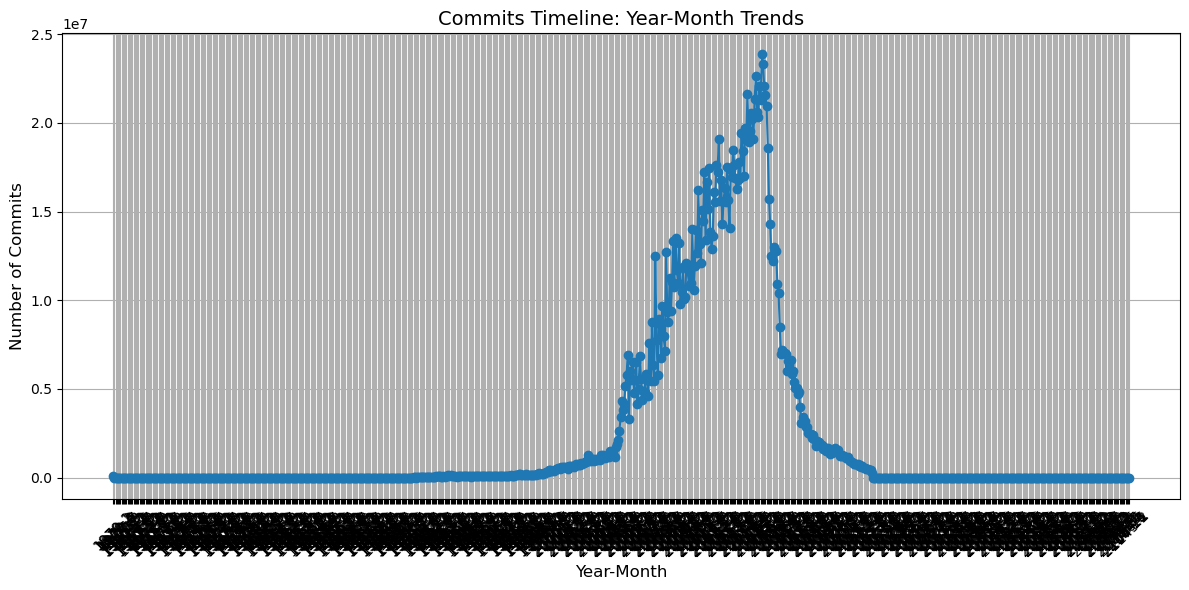

In [ ]:
from pyspark.sql import functions as F

# Step 1: Extracting the commit date
commits_with_date = commits_cleaned.withColumn(
    "commit_date", F.from_unixtime("author_time_sec").cast("date")
)

# Step 2: Aggregating commits by year and month
commits_timeline = commits_with_date.groupBy(
    F.year("commit_date").alias("year"),
    F.month("commit_date").alias("month")
).count().orderBy("year", "month")

# Step 3: Displaying the timeline data
print("Timeline of commits grouped by year and month:")
commits_timeline.show(10, truncate=False)

# Step 4: Plotting the timeline (Optional: requires matplotlib or other visualization libraries)
timeline_pandas = commits_timeline.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(
    timeline_pandas["year"].astype(str) + "-" + timeline_pandas["month"].astype(str),
    timeline_pandas["count"],
    marker="o",
    linestyle="-",
)
plt.xticks(rotation=45, fontsize=10)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Number of Commits", fontsize=12)
plt.title("Commits Timeline: Year-Month Trends", fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()


### Step 4.1: Timeline Analysis (2008-2022) for the `commits` Dataset

#### Objective:
We are filtering and analyzing the `commits` dataset to study temporal trends between 2008 and 2022.

#### Steps:
- Filtering the `commits` dataset to include data only between the years 2008 and 2022.
- Analyzing the temporal trends in the filtered dataset to observe patterns over time.
- Identifying significant peaks, valleys, and any gaps in the data for further investigation.


Filtered timeline of commits (2008-2022):


+----+-----+--------+
|year|month|count   |
+----+-----+--------+
|2008|1    |8952369 |
|2008|2    |8671325 |
|2008|3    |6729519 |
|2008|4    |9683652 |
|2008|5    |7978406 |
|2008|6    |7134856 |
|2008|7    |12697171|
|2008|8    |9330158 |
|2008|9    |8791294 |
|2008|10   |11238541|
+----+-----+--------+
only showing top 10 rows



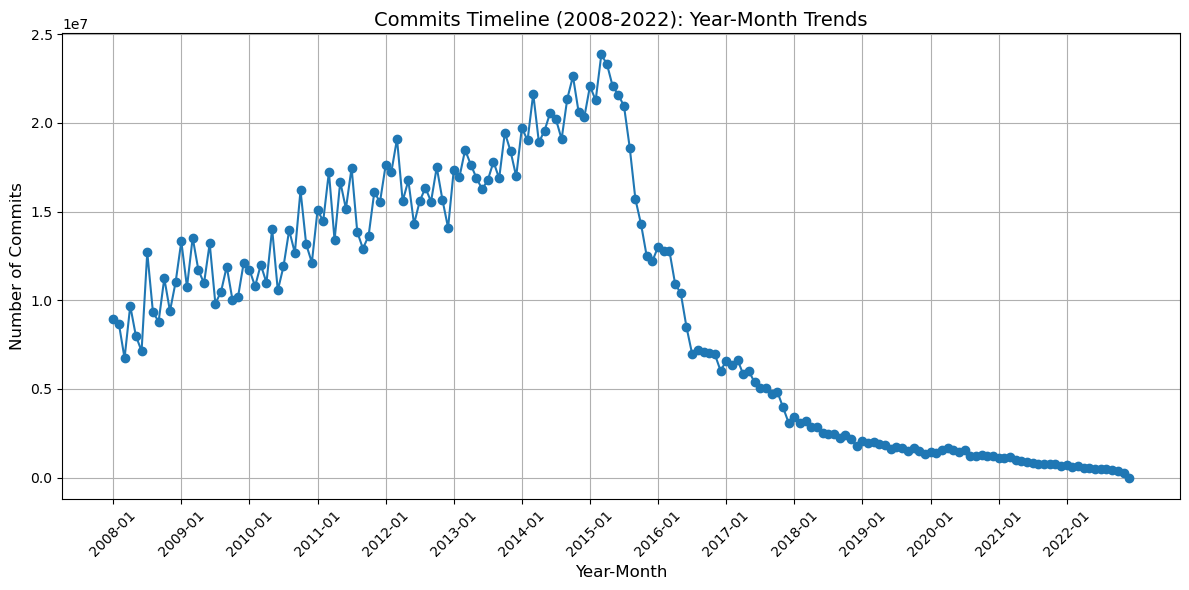

In [10]:
from pyspark.sql import functions as F

# Step 1: Extracting the commit date and filtering by years (2008-2022)
commits_filtered = commits_cleaned.withColumn(
    "commit_date", F.from_unixtime("author_time_sec").cast("date")
).filter(
    (F.year("commit_date") >= 2008) & (F.year("commit_date") <= 2022)
)

# Step 2: Aggregating commits by year and month
commits_timeline_filtered = commits_filtered.groupBy(
    F.year("commit_date").alias("year"),
    F.month("commit_date").alias("month")
).count().orderBy("year", "month")

# Step 3: Displaying the timeline data
print("Filtered timeline of commits (2008-2022):")
commits_timeline_filtered.show(10, truncate=False)

# Step 4: Plotting the timeline with cleaned X-axis labels
timeline_pandas_filtered = commits_timeline_filtered.toPandas()

import matplotlib.pyplot as plt

# Creating a combined Year-Month label for X-axis
timeline_pandas_filtered["year_month"] = (
    timeline_pandas_filtered["year"].astype(str) + "-" + 
    timeline_pandas_filtered["month"].astype(str).str.zfill(2)
)

plt.figure(figsize=(12, 6))
plt.plot(
    timeline_pandas_filtered["year_month"],
    timeline_pandas_filtered["count"],
    marker="o",
    linestyle="-",
)
plt.xticks(
    ticks=range(0, len(timeline_pandas_filtered["year_month"]), 12),  # Tick every 12 months
    labels=timeline_pandas_filtered["year_month"][::12],             # Labels for every 12 months
    rotation=45,
    fontsize=10
)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Number of Commits", fontsize=12)
plt.title("Commits Timeline (2008-2022): Year-Month Trends", fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()


### Step 4.2: Identifying Spikes and Lows in the Timeline

#### Objective:
We are identifying spikes and lows in the commit timeline by analyzing deviations from the mean and visualizing the results.

#### Steps:
- Calculating spikes and lows using the mean and standard deviation of the number of commits:
  - **Spikes**: Data points greater than `mean + std`.
  - **Lows**: Data points lower than `mean - std`.
- Visualizing the results with:
  1. **Double Bar Graph**: Highlighting spikes and lows for better clarity.
  2. **Line Graph**: Showing the full timeline to provide a complete reference.


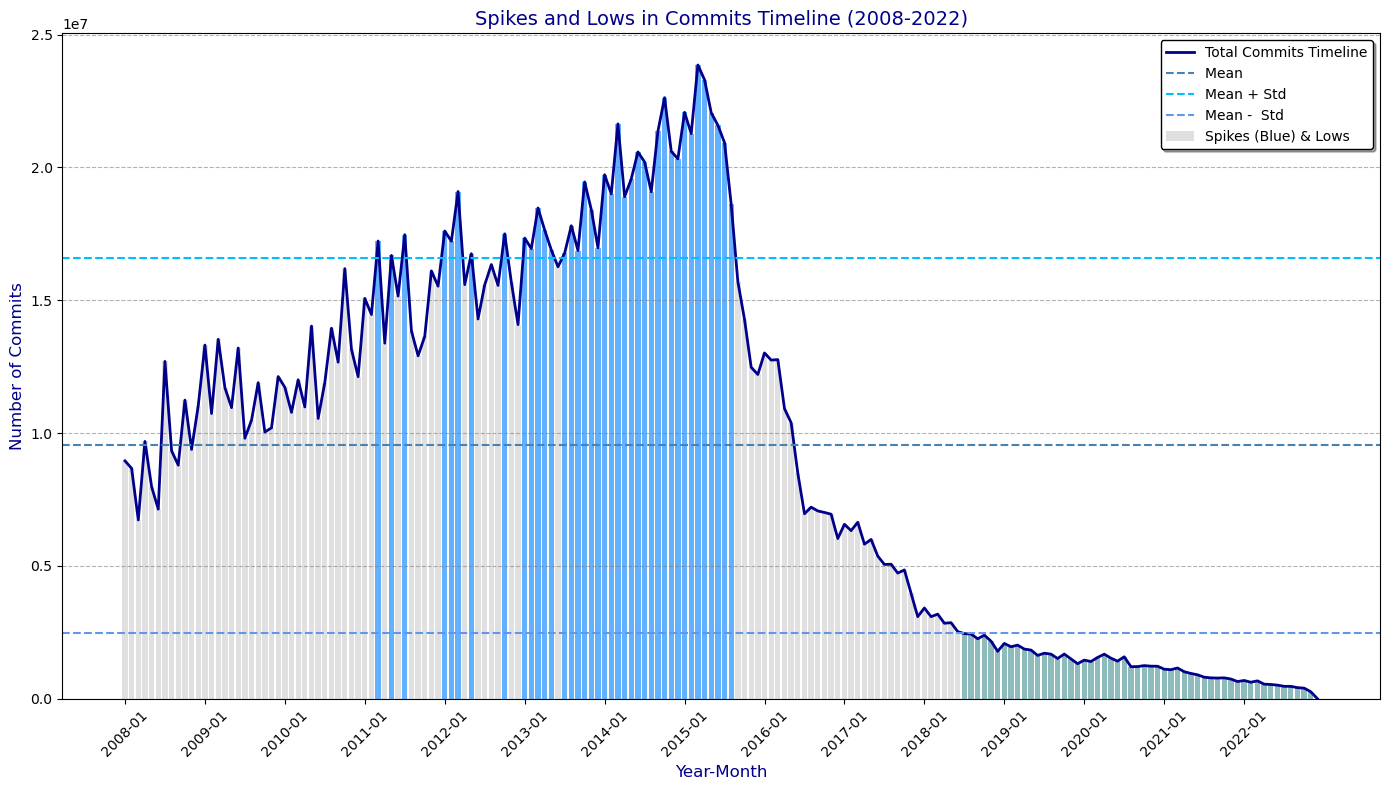

In [22]:
# Step 1: Convert timeline data to Pandas for analysis
timeline_pandas_filtered = commits_timeline_filtered.toPandas()

# Step 2: Calculate mean and standard deviation
mean_commits = timeline_pandas_filtered["count"].mean()
std_commits = timeline_pandas_filtered["count"].std()

# Step 3: Create a "year_month" column for better labels
timeline_pandas_filtered["year_month"] = (
    timeline_pandas_filtered["year"].astype(str) + "-" +
    timeline_pandas_filtered["month"].astype(str).str.zfill(2)
)

# Step 4: Identify spikes and lows
timeline_pandas_filtered["type"] = "normal"
timeline_pandas_filtered.loc[
    timeline_pandas_filtered["count"] > mean_commits +  std_commits, "type"
] = "spike"
timeline_pandas_filtered.loc[
    timeline_pandas_filtered["count"] < mean_commits -  std_commits, "type"
] = "low"

# Step 5: Create the visualization
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 8))

# Bar chart for spikes and lows with blue shades
bar_colors = timeline_pandas_filtered["type"].map(
    {"spike": "#1E90FF", "low": "#5F9EA0", "normal": "#D3D3D3"}  # Different blue shades and gray for normal
)
plt.bar(
    timeline_pandas_filtered["year_month"],
    timeline_pandas_filtered["count"],
    color=bar_colors,
    alpha=0.7,
    label="Spikes (Blue) & Lows ",
)

# Line chart for the overall trend
plt.plot(
    timeline_pandas_filtered["year_month"],
    timeline_pandas_filtered["count"],
    color="#00008B",  # Dark blue for line chart
    linewidth=2,
    label="Total Commits Timeline",
)

# Highlighting key points
plt.axhline(mean_commits, color="#4682B4", linestyle="--", label="Mean ")
plt.axhline(mean_commits + std_commits, color="#00BFFF", linestyle="--", label="Mean + Std ")
plt.axhline(mean_commits - std_commits, color="#6495ED", linestyle="--", label="Mean -  Std ")

# Formatting the plot
plt.xticks(
    ticks=np.arange(0, len(timeline_pandas_filtered["year_month"]), 12),
    labels=timeline_pandas_filtered["year_month"][::12],
    rotation=45,
    fontsize=10,
)
plt.xlabel("Year-Month", fontsize=12, color="#00008B")
plt.ylabel("Number of Commits", fontsize=12, color="#00008B")
plt.title("Spikes and Lows in Commits Timeline (2008-2022)", fontsize=14, color="#00008B")
plt.legend(frameon=True, shadow=True, edgecolor="black", fontsize=10)
plt.grid(axis="y", linestyle="--", color="gray", alpha=0.6)
plt.tight_layout()
plt.show()


### Step 5.1: Programming Language Popularity Analysis

#### Objectives:
We are identifying the most popular programming languages based on total usage (in bytes) and examining how their popularity has evolved over time.

#### Methodology:
1. **Flattening the Data**:
   - Exploding the `language` array from the `languages` dataset to create individual rows for each programming language and its byte count.

2. **Calculating Popularity**:
   - Aggregating byte usage (`total_bytes`) for each programming language across the dataset to determine overall popularity.

3. **Visualizing Top Languages**:
   - Creating a horizontal bar chart for the top 10 most popular programming languages based on `total_bytes`.

4. **Trend Analysis**:
   - Joining the `languages` dataset with the `commits` dataset to associate each language with its `commit_date`.
   - Aggregating byte usage for each language by year to analyze their evolution over time.
   - Visualizing trends for the top 5 most popular languages in a line graph.

#### Insights:
- The bar chart is providing a clear view of the most popular programming languages by total usage.
- The line graph is showing the yearly trends for the top 5 languages, highlighting significant changes in their popularity over time.

#### Deliverable:
- A horizontal bar chart for the top 10 programming languages.
- A line graph displaying the evolution of the top 5 languages over time.


Top 10 most popular programming languages:


+-------------+-------------+
|language_name|total_bytes  |
+-------------+-------------+
|C            |5044175499251|
|JavaScript   |1188804023779|
|C++          |473793956634 |
|PHP          |401050057399 |
|HTML         |321379673469 |
|Java         |288446604427 |
|Python       |177081417757 |
|CSS          |134003213728 |
|C#           |122917853882 |
|Assembly     |111145230034 |
+-------------+-------------+
only showing top 10 rows



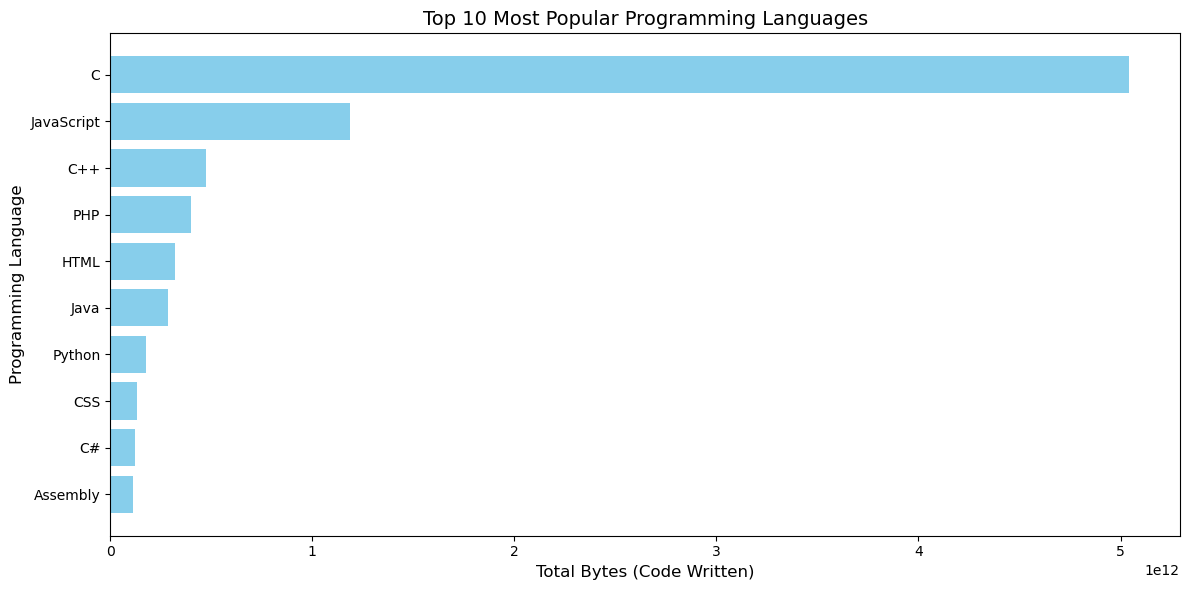

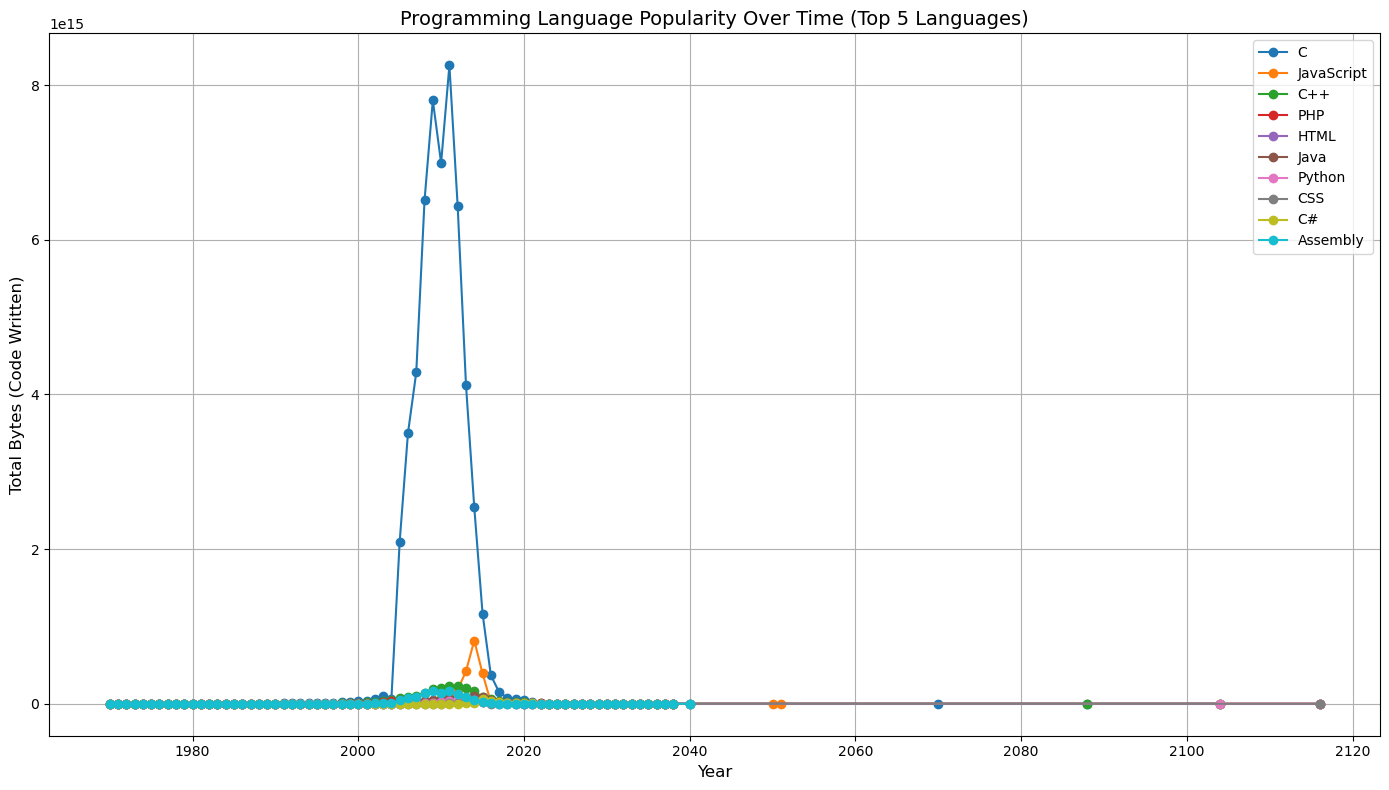

In [ ]:
from pyspark.sql import functions as F

# Step 1: Aggregate bytes by language to determine total usage
language_popularity = languages_filtered.groupBy("language_name").agg(
    F.sum("language_bytes").alias("total_bytes")  # Corrected column name
).orderBy(F.desc("total_bytes"))

# Step 2: Display top 10 most popular programming languages
print("Top 10 most popular programming languages:")
language_popularity.show(10, truncate=False)

# Step 3: Visualize the overall popularity
top_languages = language_popularity.limit(10).toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(
    top_languages["language_name"],
    top_languages["total_bytes"],
    color="skyblue",
)
plt.xlabel("Total Bytes (Code Written)", fontsize=12)
plt.ylabel("Programming Language", fontsize=12)
plt.title("Top 10 Most Popular Programming Languages", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.tight_layout()
plt.show()

# Step 4: Analyze popularity over time
# Join `languages_filtered` with `commits_sampled` to get the commit_date
languages_with_date = languages_filtered.join(
    commits_sampled.select("repo_name", "author_time_sec"),
    on="repo_name",
    how="inner"
).withColumn(
    "commit_date", F.from_unixtime("author_time_sec").cast("date")
).withColumn(
    "year", F.year("commit_date")
)

# Aggregate usage by year and language
language_trends = languages_with_date.groupBy("year", "language_name").agg(
    F.sum("language_bytes").alias("total_bytes")  # Corrected column name
).orderBy("year", F.desc("total_bytes"))

# Step 5: Visualize trends for the top 5 languages
top_5_languages = top_languages["language_name"].tolist()
language_trends_filtered = language_trends.filter(
    F.col("language_name").isin(top_5_languages)
).toPandas()

plt.figure(figsize=(14, 8))
for language in top_5_languages:
    language_data = language_trends_filtered[
        language_trends_filtered["language_name"] == language
    ]
    plt.plot(
        language_data["year"], 
        language_data["total_bytes"], 
        marker="o", 
        label=language
    )

plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Bytes (Code Written)", fontsize=12)
plt.title("Programming Language Popularity Over Time (Top 5 Languages)", fontsize=14)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Step 5.2: Programming Language Popularity Over Time (2008-2022)

#### Objective:
We are analyzing programming language popularity trends between **2008 and 2022**. To address the extreme peak in the programming language **C**, a **logarithmic scale** is applied to the y-axis for better proportionality and visualization.

#### Approach:
1. Filtering the data to include only years between **2008 and 2022**.
2. Plotting trends for the **top 5 programming languages** based on the total bytes of code written.
3. Applying a **logarithmic scale** to the y-axis to compress extreme peaks while preserving relative trends.

#### Insights:
- The **logarithmic scale** is ensuring proportionality, making significant trends across all languages more visible.
- The extreme popularity of **C** is remaining visible without overshadowing other languages.
- Peaks and valleys in language usage over time are being clearly represented.

#### Visualization Details:
- **X-axis**: Representing years from 2008 to 2022.
- **Y-axis**: Logarithmic scale representing total bytes of code written.
- **Line Plot**: Showing trends for the top 10 programming languages.


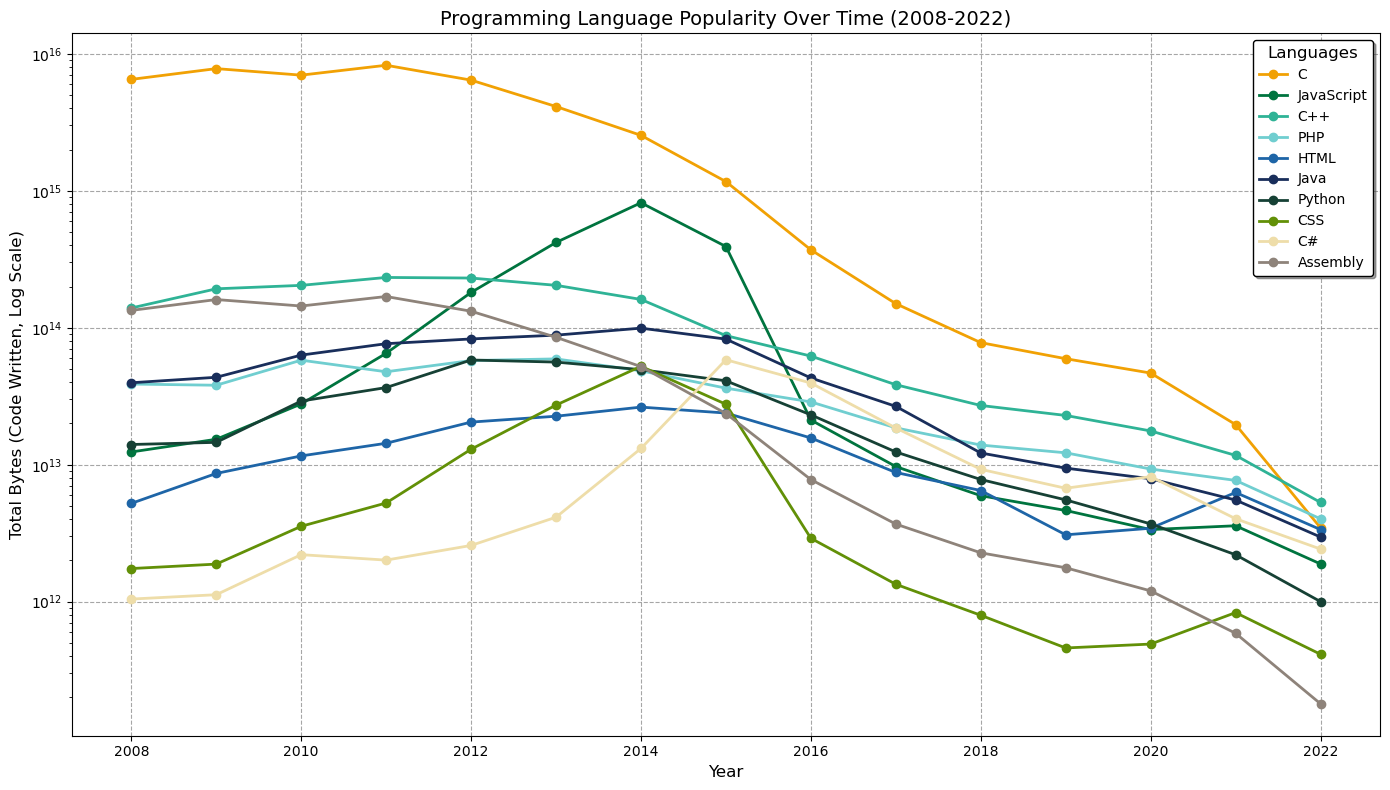

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Filter trends for the years 2008-2022
language_trends_filtered = language_trends.filter(
    (F.col("year") >= 2008) & (F.col("year") <= 2022)
).toPandas()

# Define the color palette from the new image
grass_palette = [
    "#F1A104", #DARK YELLOW
    "#00743F", #GREEN
    "#2FB396", #LIGHT GREEN
    "#70CED0", #LIGHT BLUE,
    "#1E65A7", #DARK BLUE,
    "#192E5B", #NAVY BLUE
    "#164135",  # Dark Green
    "#629007",  # Bright Green
    "#EEDDA9",  # Beige
    "#8E837A",  # Taupe
    "#54696D",  # Blue-Gray
    "#f15704", #ORANGE
    
]

# Initialize the plot
plt.figure(figsize=(14, 8))

# Plot trends for each top language
for idx, language in enumerate(top_5_languages):
    language_data = language_trends_filtered[
        language_trends_filtered["language_name"] == language
    ]
    plt.plot(
        language_data["year"],
        language_data["total_bytes"],
        marker="o",
        label=language,
        color=grass_palette[idx % len(grass_palette)],  # Cycle through grass palette
        linewidth=2,
    )

# Add logarithmic scale for y-axis
plt.yscale("log")

# Add labels, title, and legend
plt.xlabel("Year", fontsize=12, color="black")
plt.ylabel("Total Bytes (Code Written, Log Scale)", fontsize=12, color="black")
plt.title("Programming Language Popularity Over Time (2008-2022)", fontsize=14, color="black")
plt.legend(
    title="Languages",
    fontsize=10,
    title_fontsize=12,
    frameon=True,
    shadow=True,
    edgecolor="black",
)
plt.grid(axis="both", linestyle="--", color="gray", alpha=0.7)  # Light gray gridlines
plt.tight_layout()
plt.show()


### Step 5.3: Top 10 Programming Languages by Number of Commits and Their Popularity Over Time

#### Objective:
We are visualizing the number of commits associated with the top 10 programming languages and analyzing how the popularity of these languages has evolved over time from 2008 to 2022.

---

#### Process:

**Bar Graph: Top 10 Programming Languages by Number of Commits**  
1. **Flattening the `languages_filtered` Dataset**:  
   - Exploding the `languages` array in the `languages_filtered` dataset to extract `language_name` and its associated details.  

2. **Joining with `commits_sampled`**:  
   - Joining the flattened dataset with `commits_sampled` on `repo_name` to link commits to their respective programming languages.  

3. **Aggregating the Data**:  
   - Grouping the data by `language_name` and counting the total number of commits for each language.  
   - Sorting the results in descending order to identify the most popular languages by commits.  

4. **Selecting Top 10 Languages**:  
   - Filtering the results to include only the top 10 programming languages with the highest commit volumes.  

5. **Creating a Bar Graph**:  
   - Plotting a bar graph to display the top 10 programming languages on the x-axis and their corresponding commit counts on the y-axis.  
   - Applying a distinct color palette for enhanced visualization.  

---

**Line Graph: Programming Language Popularity Over Time**  
1. **Extracting Year Information**:  
   - Extracting the `year` from the `author_time_sec` column in `commits_sampled` to filter the data between 2008 and 2022.  

2. **Aggregating Data by Language and Year**:  
   - Grouping the data by `language_name` and `year` to count the total number of commits for each combination.  
   - Ordering the results by year to analyze trends.  

3. **Filtering for Top 10 Languages**:  
   - Limiting the data to include only the top 10 programming languages identified in the bar graph.  

4. **Creating a Line Graph**:  
   - Plotting a line graph for each of the top 10 programming languages to show the yearly commit trends.  
   - Using the following visualization details:  
     - **X-axis**: Representing the year.  
     - **Y-axis**: Total number of commits (logarithmic scale for better proportionality).  
     - **Color Palette**: Assigning a unique color to each language for clarity.  

---

#### Deliverables:
- A bar graph showing the top 10 programming languages by total commits.  
- A line graph depicting the evolution of commit trends for the top 10 programming languages over time.


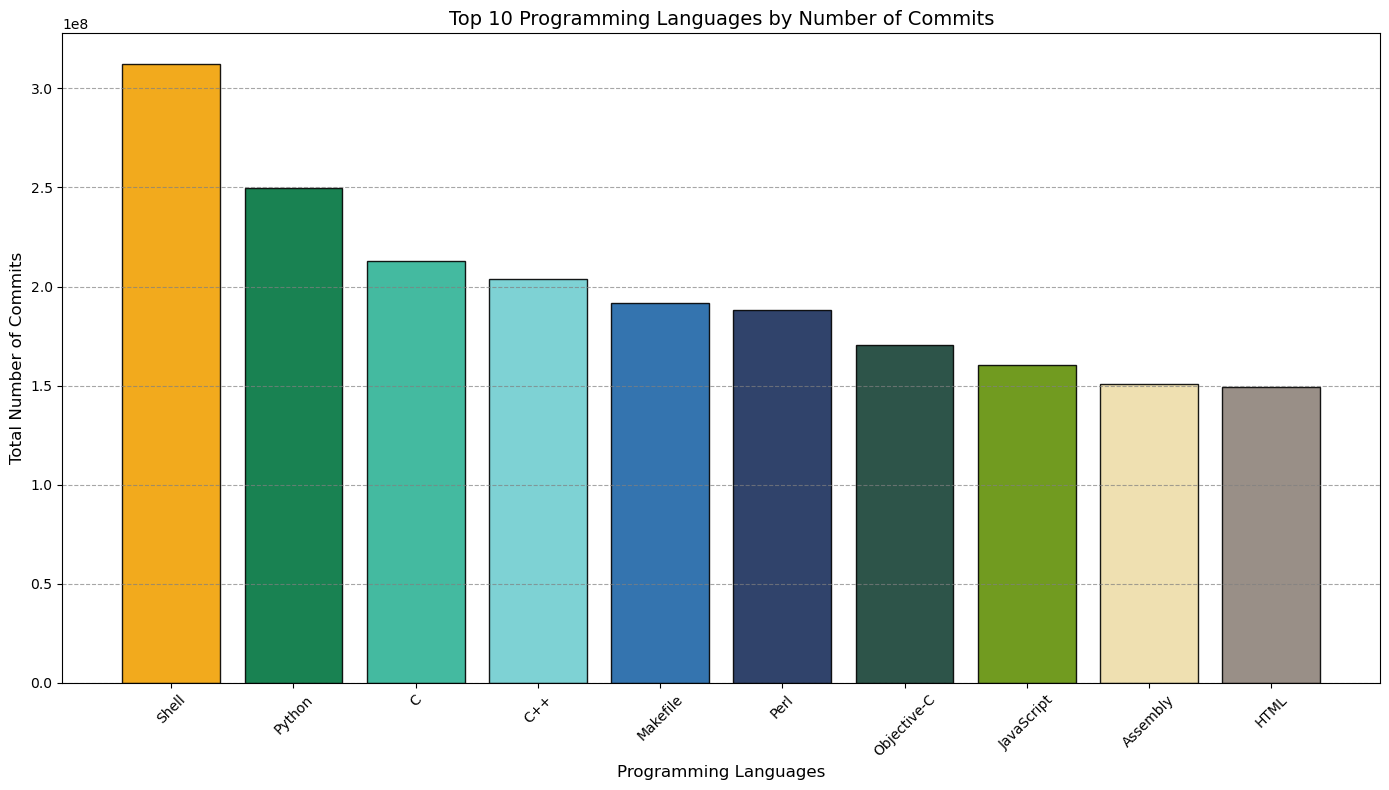

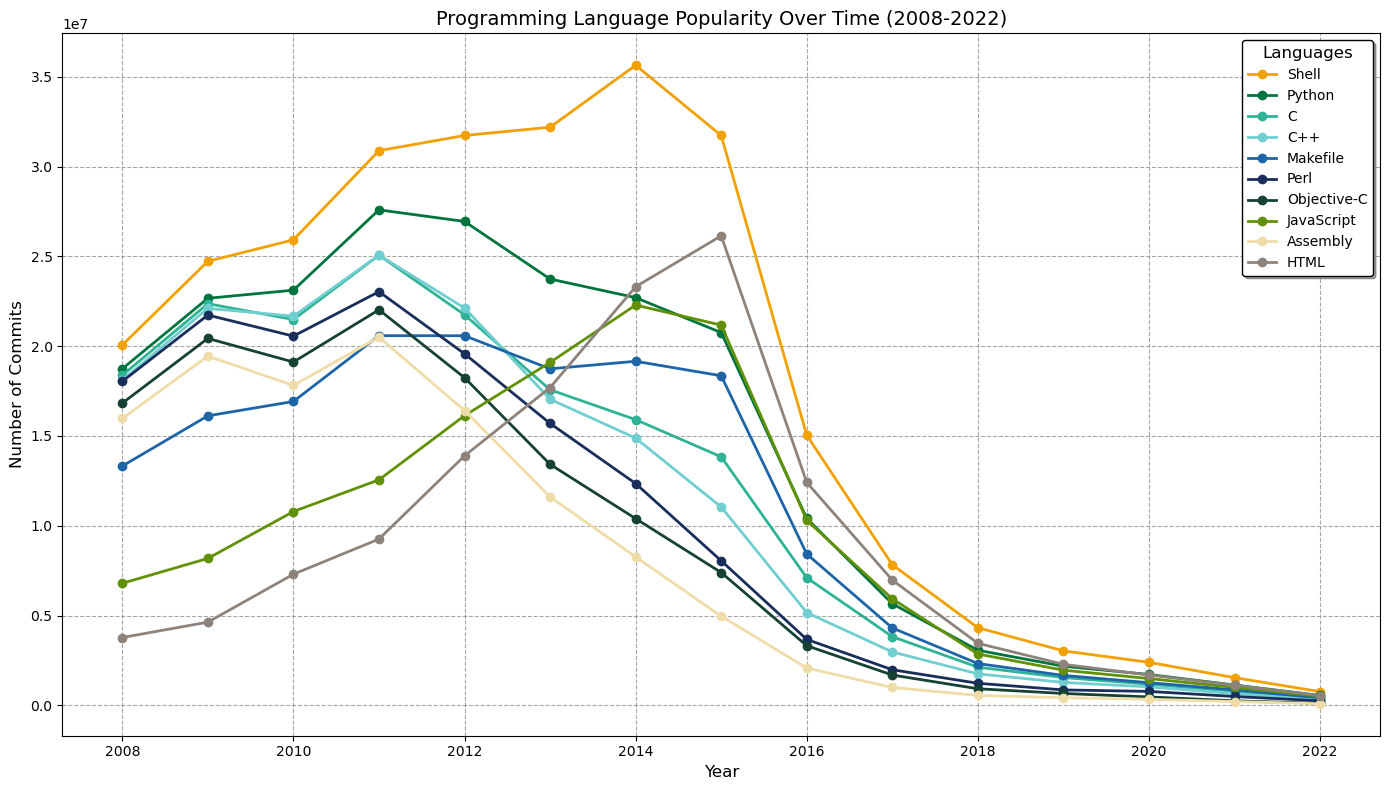

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Define the color palette from the uploaded image
grass_palette = [
    "#F1A104",  # Dark Yellow
    "#00743F",  # Green
    "#2FB396",  # Light Green
    "#70CED0",  # Light Blue
    "#1E65A7",  # Dark Blue
    "#192E5B",  # Navy Blue
    "#164135",  # Dark Green
    "#629007",  # Bright Green
    "#EEDDA9",  # Beige
    "#8E837A",  # Taupe
    "#54696D",  # Blue-Gray
    "#f15704",  # Orange
]

# Step 1: Use the cleaned and exploded languages dataset
languages_flat = languages_filtered.select(
    F.col("repo_name"),
    F.col("language_name").alias("language_name")
)

# Step 2: Join with commits_sampled on repo_name
language_commit_data = languages_flat.join(
    commits_sampled,
    on=languages_flat.repo_name == commits_sampled.repo_name,
    how="inner"
)

# Step 3: Aggregate data
language_commit_counts = language_commit_data.groupBy("language_name").agg(
    F.count("commit").alias("total_commits")
).orderBy(F.desc("total_commits"))

# Step 4: Top 10 languages by total commits
top_languages = language_commit_counts.limit(10).toPandas()

# Step 5: Bar Graph: Top 10 Programming Languages by Commits
plt.figure(figsize=(14, 8))
plt.bar(
    top_languages["language_name"],
    top_languages["total_commits"],
    color=grass_palette[: len(top_languages)],
    edgecolor="black",
    alpha=0.9,
)
plt.xlabel("Programming Languages", fontsize=12, color="black")
plt.ylabel("Total Number of Commits", fontsize=12, color="black")
plt.title("Top 10 Programming Languages by Number of Commits", fontsize=14, color="black")
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", color="gray", alpha=0.7)
plt.tight_layout()
plt.show()

# Step 6: Line Graph: Language Popularity Over Time
# Extract year from author_time_sec
language_commit_data_with_year = language_commit_data.withColumn(
    "year",
    F.year(F.from_unixtime(F.col("author_time_sec")))
).filter((F.col("year") >= 2008) & (F.col("year") <= 2022))

# Aggregate by language and year
language_yearly_commits = language_commit_data_with_year.groupBy("language_name", "year").agg(
    F.count("commit").alias("total_commits")
).orderBy("year")

# Convert to Pandas for visualization
language_yearly_commits_pandas = language_yearly_commits.toPandas()

# Filter for top 10 languages
top_language_list = top_languages["language_name"].tolist()
filtered_language_trends = language_yearly_commits_pandas[
    language_yearly_commits_pandas["language_name"].isin(top_language_list)
]

# Initialize the plot
plt.figure(figsize=(14, 8))

# Plot trends for each language
for idx, language in enumerate(top_language_list):
    language_data = filtered_language_trends[
        filtered_language_trends["language_name"] == language
    ]
    plt.plot(
        language_data["year"],
        language_data["total_commits"],
        marker="o",
        label=language,
        color=grass_palette[idx % len(grass_palette)],  # Use the new palette
        linewidth=2,
    )

# Add labels, title, and legend
plt.xlabel("Year", fontsize=12, color="black")
plt.ylabel("Number of Commits", fontsize=12, color="black")
plt.title("Programming Language Popularity Over Time (2008-2022)", fontsize=14, color="black")
plt.legend(
    title="Languages",
    fontsize=10,
    title_fontsize=12,
    frameon=True,
    shadow=True,
    edgecolor="black",
)
plt.grid(axis="both", linestyle="--", color="gray", alpha=0.7)
plt.tight_layout()
plt.show()


### Step 6.1: Distribution of Licenses and Their Association with Programming Languages

#### Objective:
We are exploring the distribution of licenses across GitHub repositories and identifying correlations between specific programming languages and licenses.

---

#### Process:

**License Distribution Analysis**  
1. **Aggregating the Data**:  
   - Grouping the `licenses_filtered` dataset by `license` to calculate the total count of repositories for each license.  

2. **Filtering the Top 10 Licenses**:  
   - Limiting the analysis to the top 10 licenses with the highest repository count.  

3. **Creating a Bar Graph**:  
   - Visualizing the distribution of the top 10 licenses using a horizontal bar graph.  
   - Applying a new color palette to improve aesthetics and clarity.  

---

**License and Language Association Analysis**  
1. **Joining Datasets**:  
   - Performing an inner join on the `repo_name` column between the `licenses_filtered` and `languages_filtered` datasets to associate licenses with programming languages.  

2. **Aggregating the Data**:  
   - Grouping the joined dataset by `license` and `language_name` to count the total number of repositories for each combination.  

3. **Pivoting the Data**:  
   - Creating a pivot table to visualize the relationship between licenses and programming languages.  

4. **Creating a Heatmap**:  
   - Visualizing the associations between licenses and languages using a heatmap.  
   - Applying a distinct color palette to highlight patterns and relationships effectively.  

---

#### Deliverables:
- A horizontal bar graph showing the distribution of the top 10 licenses by repository count.  
- A heatmap depicting the relationship between licenses and programming languages.


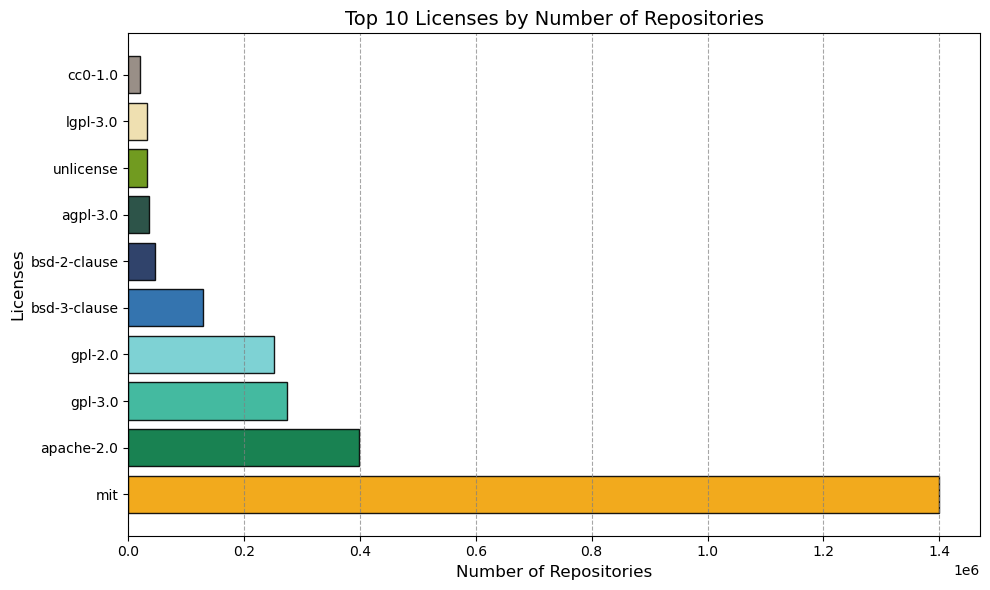

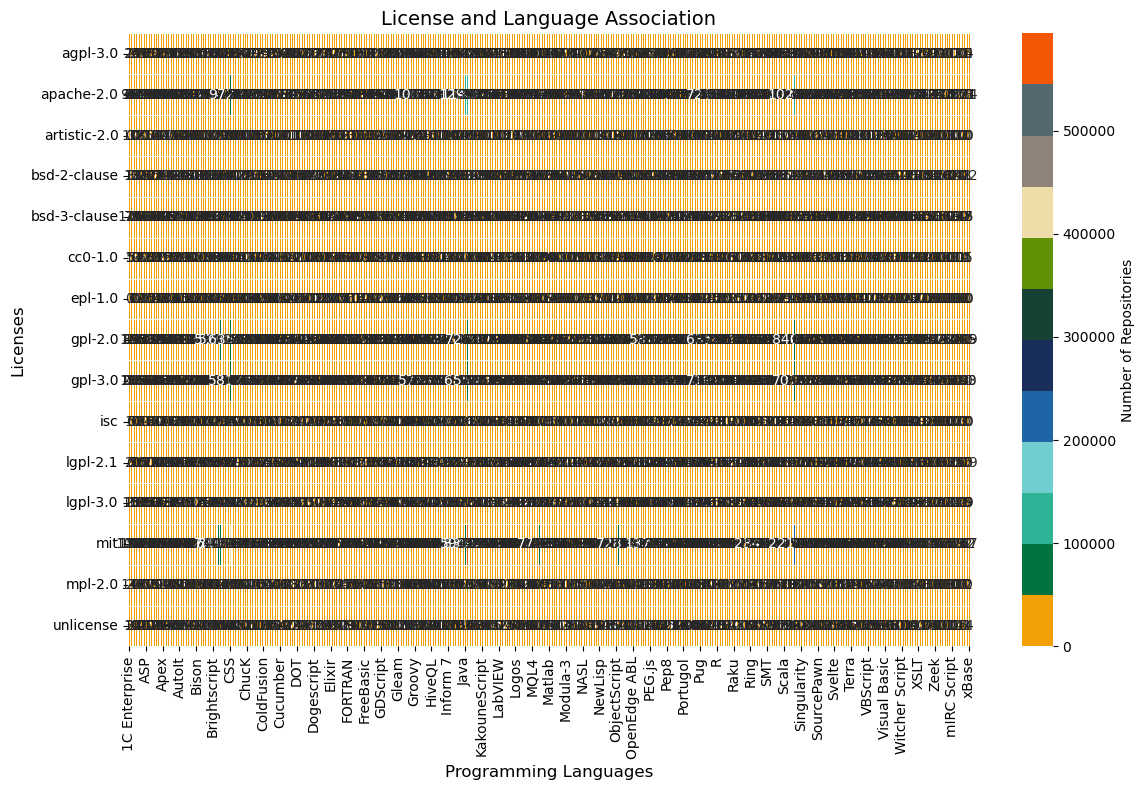

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Define the new color palette
grass_palette = [
    "#F1A104", #DARK YELLOW
    "#00743F", #GREEN
    "#2FB396", #LIGHT GREEN
    "#70CED0", #LIGHT BLUE,
    "#1E65A7", #DARK BLUE,
    "#192E5B", #NAVY BLUE
    "#164135",  # Dark Green
    "#629007",  # Bright Green
    "#EEDDA9",  # Beige
    "#8E837A",  # Taupe
    "#54696D",  # Blue-Gray
    "#f15704", #ORANGE
    
]

# Step 1: License Distribution
license_distribution = licenses_filtered.groupBy("license").agg(
    F.count("repo_name").alias("total_repos")
).orderBy(F.desc("total_repos"))

# Convert to Pandas for visualization
license_distribution_pandas = license_distribution.limit(10).toPandas()

# Bar Graph: Top 10 Licenses
plt.figure(figsize=(10, 6))
plt.barh(
    license_distribution_pandas["license"],
    license_distribution_pandas["total_repos"],
    color=grass_palette[: len(license_distribution_pandas)],
    edgecolor="black",
    alpha=0.9,
)
plt.xlabel("Number of Repositories", fontsize=12, color="black")
plt.ylabel("Licenses", fontsize=12, color="black")
plt.title("Top 10 Licenses by Number of Repositories", fontsize=14, color="black")
plt.grid(axis="x", linestyle="--", color="gray", alpha=0.7)
plt.tight_layout()
plt.show()

# Step 2: License and Language Association
license_language_data = licenses_filtered.join(
    languages_filtered,
    on="repo_name",
    how="inner"
).groupBy("license", "language_name").agg(
    F.count("repo_name").alias("total_repos")
)

# Convert to Pandas and Pivot
license_language_pandas = license_language_data.toPandas()
pivot_table = license_language_pandas.pivot(
    index="license", columns="language_name", values="total_repos"
).fillna(0)

# Heatmap: License and Language Association
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table,
    cmap=grass_palette[: len(pivot_table.columns)],
    linewidths=0.5,
    linecolor="white",
    annot=True,
    fmt="g",
    cbar_kws={"label": "Number of Repositories"},
)
plt.title("License and Language Association", fontsize=14, color="black")
plt.xlabel("Programming Languages", fontsize=12, color="black")
plt.ylabel("Licenses", fontsize=12, color="black")
plt.tight_layout()
plt.show()

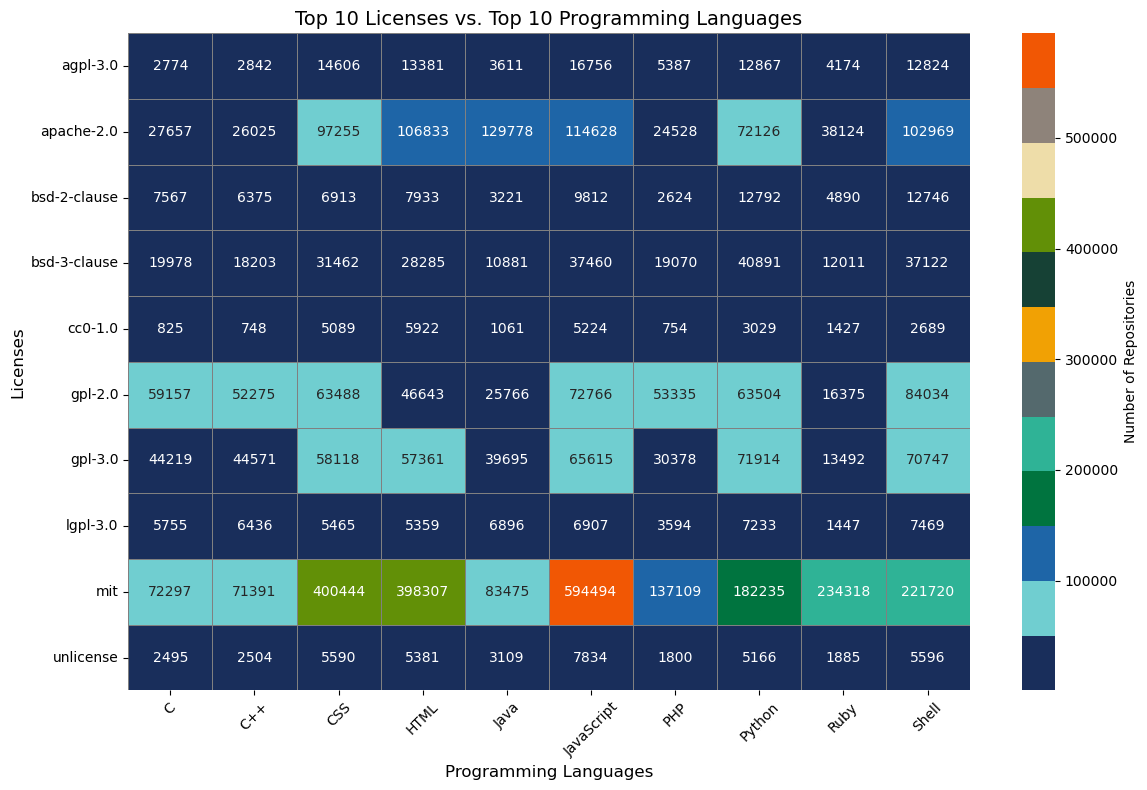

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

grass_palette = [
    "#192E5B", #NAVY BLUE
    "#70CED0", #LIGHT BLUE,
    "#1E65A7", #DARK BLUE,
    "#00743F", #GREEN
    "#2FB396", #LIGHT GREEN
    "#54696D",  # Blue-Gray
    "#F1A104", #DARK YELLOW
    "#164135",  # Dark Green
    "#629007",  # Bright Green
    "#EEDDA9",  # Beige
    "#8E837A",  # Taupe
    "#f15704", #ORANGE
    
]

# Step 1: Aggregate top 10 programming languages by the number of repositories
top_languages_by_repos = licenses_filtered.join(
    languages_filtered, on="repo_name", how="inner"
).groupBy("language_name").agg(F.countDistinct("repo_name").alias("repo_count")) \
    .orderBy(F.desc("repo_count")) \
    .limit(10) \
    .toPandas()

# Step 2: Aggregate top 10 licenses by the number of repositories
top_licenses_by_repos = licenses_filtered.groupBy("license").agg(
    F.countDistinct("repo_name").alias("repo_count")
).orderBy(F.desc("repo_count")).limit(10).toPandas()

# Step 3: Filter the licenses-languages dataset to include only top 10 languages and licenses
filtered_data = licenses_filtered.join(
    languages_filtered, on="repo_name", how="inner"
).select("license", "language_name", "repo_name") \
    .filter(
        F.col("language_name").isin(top_languages_by_repos["language_name"].tolist()) &
        F.col("license").isin(top_licenses_by_repos["license"].tolist())
    )

# Step 4: Create a pivot table for the heatmap
heatmap_data = filtered_data.groupBy("license", "language_name").agg(
    F.countDistinct("repo_name").alias("repo_count")
).toPandas()

# Pivot the data for the heatmap
heatmap_pivot = heatmap_data.pivot(index="license", columns="language_name", values="repo_count").fillna(0)

# Step 5: Generate the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_pivot,
    annot=True,
    fmt=".0f",
    cmap=grass_palette,
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Number of Repositories"},
)

# Step 6: Add titles and labels
plt.title("Top 10 Licenses vs. Top 10 Programming Languages", fontsize=14, color="black")
plt.xlabel("Programming Languages", fontsize=12, color="black")
plt.ylabel("Licenses", fontsize=12, color="black")
plt.xticks(rotation=45, fontsize=10, color="black")
plt.yticks(fontsize=10, color="black")
plt.tight_layout()
plt.show()


### Step 7.1: Identify the Most Popular Repositories by Number of Commits

#### Objective:
We are identifying the repositories with the highest number of commits to represent their popularity in terms of activity. This metric is based solely on the total number of commits for each repository.

---

#### Process:
1. **Aggregating Commit Counts**:  
   - Using the `commits_sampled` dataset to calculate the total number of commits for each repository.  

2. **Sorting and Extracting Top Repositories**:  
   - Sorting the repositories in descending order of commit counts.  
   - Extracting the top 10 repositories with the highest activity.  

3. **Visualizing the Results**:  
   - Creating a **bar chart** to display the top 10 repositories by the total number of commits.  
   - Each bar represents a repository, and the bar height indicates the number of commits.  

---

#### Insights:
- This step provides insights into the most actively maintained repositories, highlighting where developers are focusing their efforts the most.  
- It sets the foundation for further exploration of repository growth trends in subsequent steps.


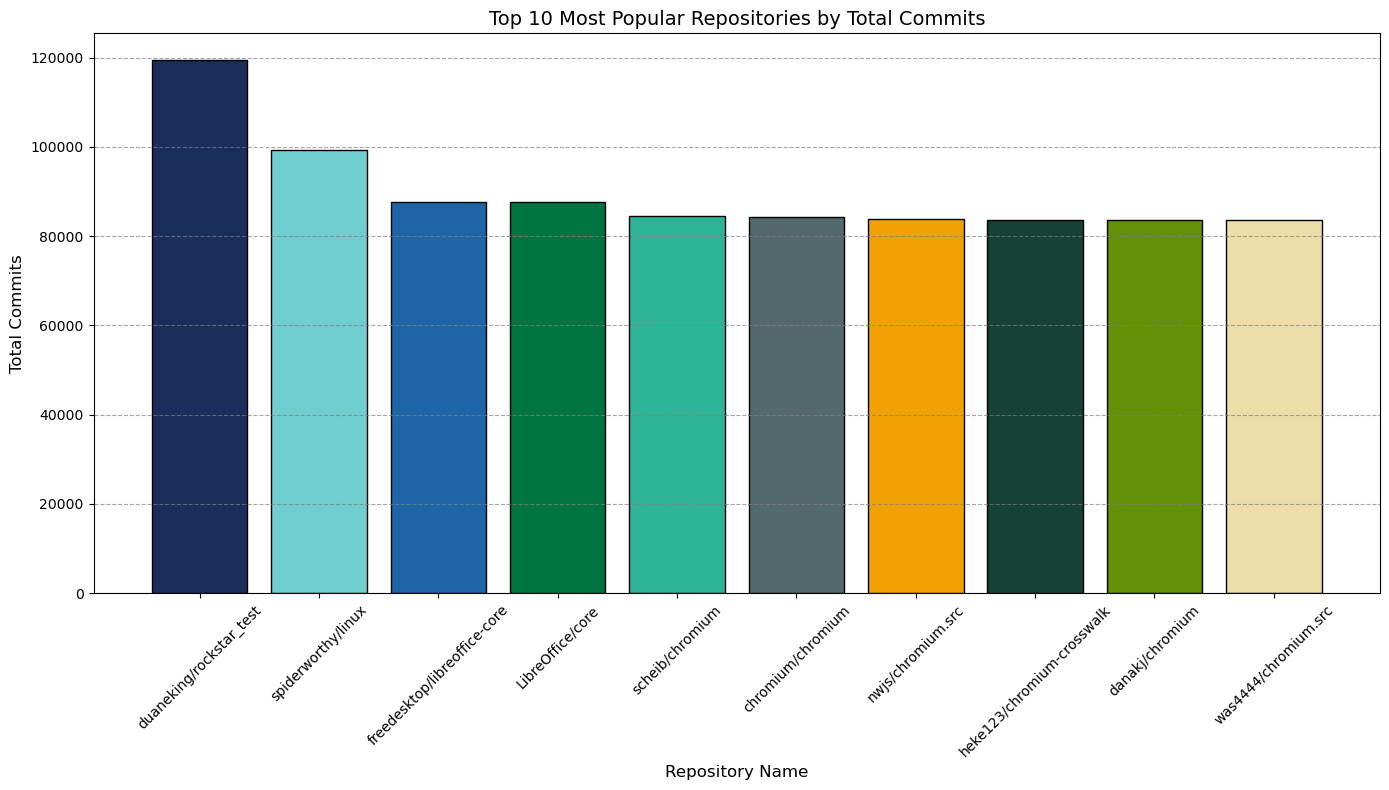

In [33]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Step 1: Aggregate Commit Counts by Repository
repo_commit_counts = commits_sampled.groupBy("repo_name").agg(
    F.count("commit").alias("total_commits")
).orderBy(F.desc("total_commits"))

# Convert to Pandas for visualization
top_repos = repo_commit_counts.limit(10).toPandas()

# Step 2: Bar Graph: Top 10 Most Popular Repositories
grass_palette = [
    "#192E5B", #NAVY BLUE
    "#70CED0", #LIGHT BLUE,
    "#1E65A7", #DARK BLUE,
    "#00743F", #GREEN
    "#2FB396", #LIGHT GREEN
    "#54696D",  # Blue-Gray
    "#F1A104", #DARK YELLOW
    "#164135",  # Dark Green
    "#629007",  # Bright Green
    "#EEDDA9",  # Beige
    "#8E837A",  # Taupe
    "#f15704", #ORANGE
    
]

plt.figure(figsize=(14, 8))
plt.bar(
    top_repos["repo_name"],
    top_repos["total_commits"],
    color=grass_palette[: len(top_repos)],
    edgecolor="black",
)
plt.title("Top 10 Most Popular Repositories by Total Commits", fontsize=14, color="black")
plt.xlabel("Repository Name", fontsize=12, color="black")
plt.ylabel("Total Commits", fontsize=12, color="black")
plt.xticks(rotation=45, fontsize=10, color="black")
plt.grid(axis="y", linestyle="--", color="gray", alpha=0.7)
plt.tight_layout()
plt.show()


### Step 7.2: Most Rapidly Growing Repositories

#### Objective:
We are identifying the repositories with the highest percentage increase in commits over time and visualizing their growth trajectories to understand rapid development patterns.

---

#### Steps:

1. **Extract Year**:  
    - Extracting the year from the `author_time_sec` field for each commit.  
   - Filtering the data to include only years between 2008 and 2022.  
   

2. **Aggregate Commit Counts**:  
   - Grouping the data by `repo_name` and `year` to calculate yearly commit counts.  

3. **Calculate Growth Rate**:  
   - Calculating the percentage growth rate for each repository using the previous year's commit count.  

4. **Identify Top Growing Repositories**:  
   - Selecting the top 10 repositories with the highest maximum growth rates.  

5. **Visualization**:  
   - Plotting a line chart to display the growth trajectories of the top 10 repositories over time.  

---

#### Output:
- A line chart showing the yearly growth in commits for the top 10 repositories with the highest growth rates.  
- This visualization highlights repositories with significant spikes in activity, revealing patterns of rapid development or increased focus.  


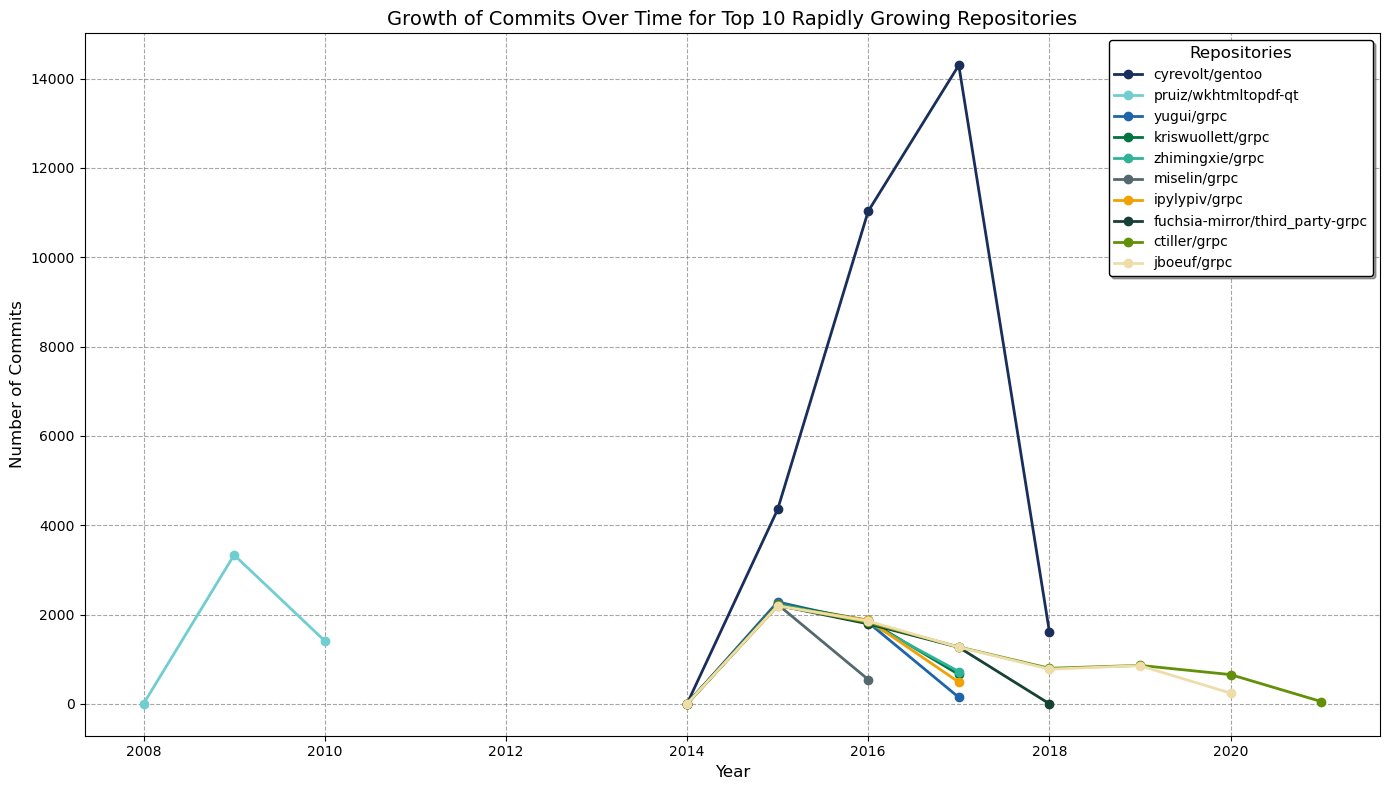

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Define the color palette
grass_palette = [
    "#192E5B",  # NAVY BLUE
    "#70CED0",  # LIGHT BLUE
    "#1E65A7",  # DARK BLUE
    "#00743F",  # GREEN
    "#2FB396",  # LIGHT GREEN
    "#54696D",  # Blue-Gray
    "#F1A104",  # DARK YELLOW
    "#164135",  # Dark Green
    "#629007",  # Bright Green
    "#EEDDA9",  # Beige
    "#8E837A",  # Taupe
    "#f15704",  # ORANGE
]

# Step 1: Extract Year from `author_time_sec`
commits_with_year = commits_sampled.withColumn(
    "year",
    F.year(F.from_unixtime(F.col("author_time_sec")))
).filter((F.col("year") >= 2008) & (F.col("year") <= 2022))

# Step 2: Aggregate Commit Counts by Repository and Year
repo_yearly_commits = commits_with_year.groupBy("repo_name", "year").agg(
    F.count("commit").alias("yearly_commits")
).orderBy("repo_name", "year")

# Step 3: Calculate Percentage Growth for Each Repository
from pyspark.sql.window import Window

window_spec = Window.partitionBy("repo_name").orderBy("year")

repo_growth = repo_yearly_commits.withColumn(
    "previous_year_commits", F.lag("yearly_commits").over(window_spec)
).withColumn(
    "growth_rate",
    F.when(
        F.col("previous_year_commits").isNotNull(),
        ((F.col("yearly_commits") - F.col("previous_year_commits")) / F.col("previous_year_commits")) * 100
    ).otherwise(0)
)

# Step 4: Identify the Top 10 Repositories with the Highest Growth Rate
top_growing_repos = repo_growth.groupBy("repo_name").agg(
    F.max("growth_rate").alias("max_growth_rate")
).orderBy(F.desc("max_growth_rate")).limit(10).toPandas()

# Step 5: Filter Growth Data for Top Repositories
top_repo_list = top_growing_repos["repo_name"].tolist()
growth_data_filtered = repo_growth.filter(F.col("repo_name").isin(top_repo_list)).toPandas()

# Step 6: Line Chart: Growth of Commits Over Time for Top Repositories
plt.figure(figsize=(14, 8))

# Plot growth trends for each repository
for idx, repo in enumerate(top_repo_list):
    repo_data = growth_data_filtered[growth_data_filtered["repo_name"] == repo]
    plt.plot(
        repo_data["year"],
        repo_data["yearly_commits"],
        marker="o",
        label=repo,
        color=grass_palette[idx % len(grass_palette)],  # Cycle through grass_palette
        linewidth=2,
    )

# Add labels, title, and legend
plt.xlabel("Year", fontsize=12, color="black")
plt.ylabel("Number of Commits", fontsize=12, color="black")
plt.title("Growth of Commits Over Time for Top 10 Rapidly Growing Repositories", fontsize=14, color="black")
plt.legend(
    title="Repositories",
    fontsize=10,
    title_fontsize=12,
    frameon=True,
    shadow=True,
    edgecolor="black",
)
plt.grid(axis="both", linestyle="--", color="gray", alpha=0.7)
plt.tight_layout()
plt.show()


### Step 8: Technologies Associated with Data Science or AI Projects

#### Objective:
We are identifying the most frequently associated technologies with Data Science or AI projects and analyzing how these trends have evolved over time.

---

#### Steps:

1. **Filter Data Science/AI Repositories**:  
   - Filtering repositories using keywords such as "AI", "ML", "Deep Learning", and similar terms found in their subjects or messages to focus on relevant projects.  

2. **Aggregate Programming Languages**:  
   - Extracting programming languages associated with the filtered repositories and aggregating their usage to identify the most popular technologies.  

3. **Visualizations**:  
   - **Bar Chart**: Displaying the top 10 programming languages by the number of repositories associated with Data Science/AI projects.  
   - **Line Chart**: Showing trends of these top technologies over time, spanning from 2008 to 2022.  

---

#### Insights:
- The bar chart provides a clear view of the most commonly used programming languages in Data Science/AI repositories.  
- The line chart reveals how the popularity of these technologies has evolved, highlighting significant trends or shifts in focus over the years.  


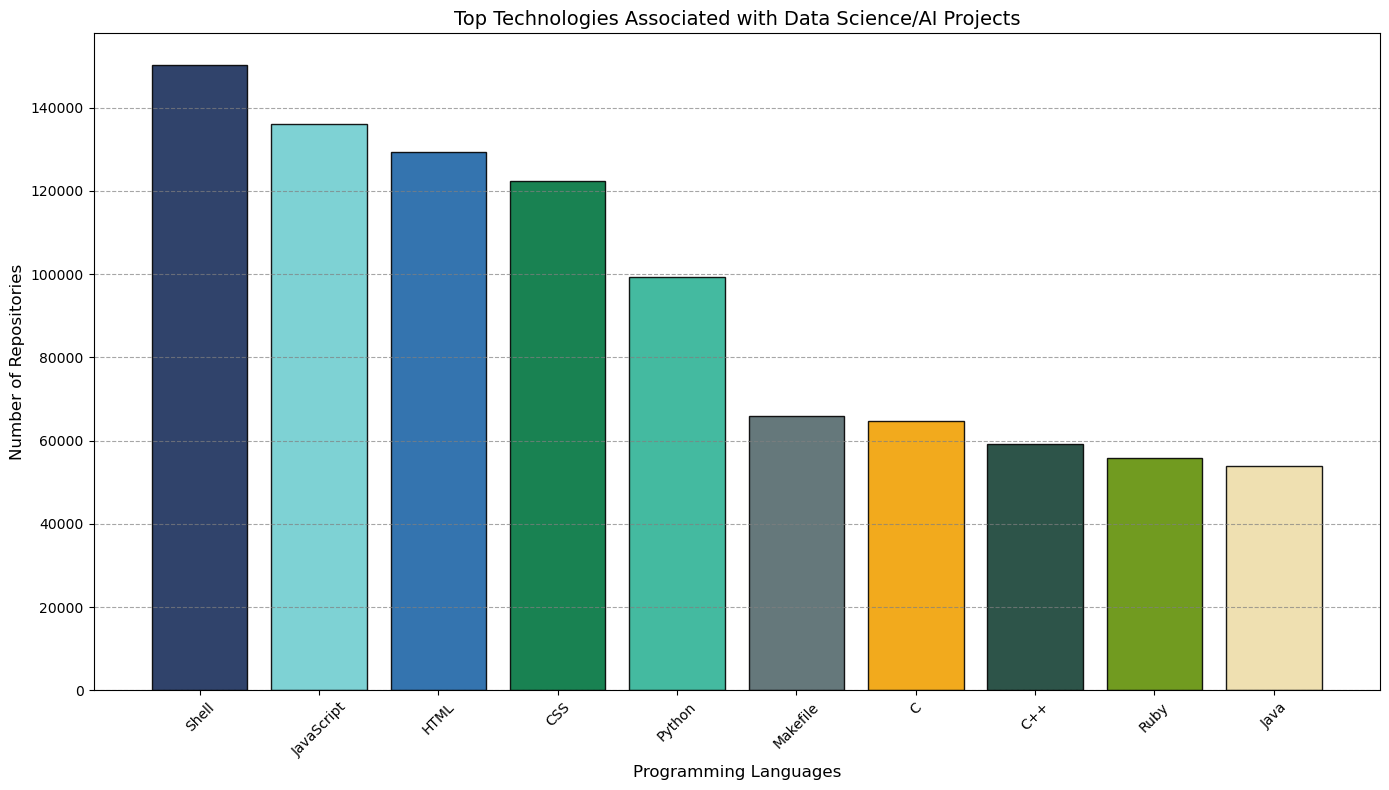

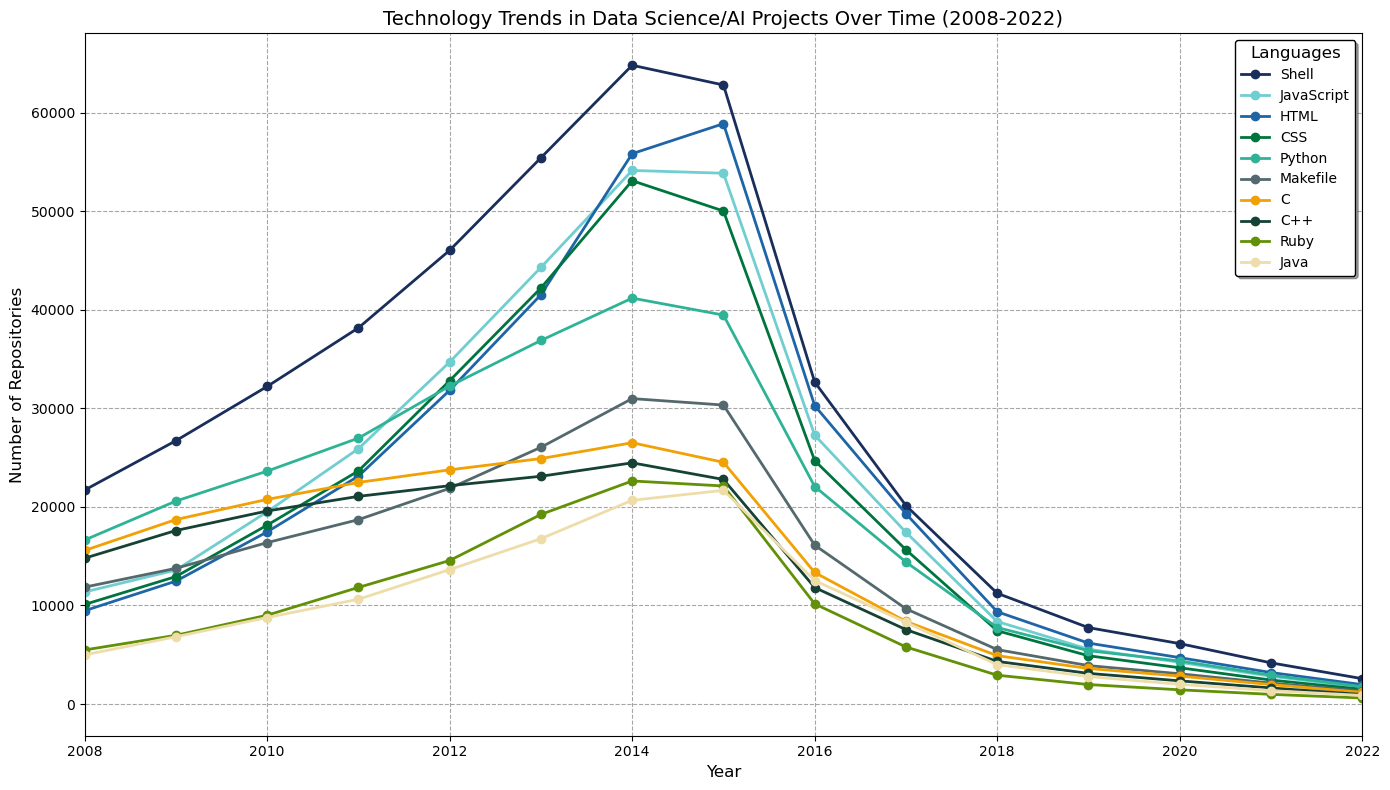

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Define the color palette
grass_palette = [
    "#192E5B",  # NAVY BLUE
    "#70CED0",  # LIGHT BLUE
    "#1E65A7",  # DARK BLUE
    "#00743F",  # GREEN
    "#2FB396",  # LIGHT GREEN
    "#54696D",  # Blue-Gray
    "#F1A104",  # DARK YELLOW
    "#164135",  # Dark Green
    "#629007",  # Bright Green
    "#EEDDA9",  # Beige
]

# Step 1: Filter Data Science/AI repositories using keywords in subject or message
keywords = [
    "AI", "ML", "Deep Learning", "Data Science", "Neural Network",
    "Machine Learning", "Artificial Intelligence", "Big Data",
    "Data Mining", "Data Analytics", "Analytics", "Data",
    "Business Intelligence"
]
data_science_repos = commits_sampled.filter(
    F.col("subject").rlike("|".join(keywords)) | F.col("message").rlike("|".join(keywords))
)

# Step 2: Extract relevant programming languages for these repositories
data_science_languages = data_science_repos.alias("ds_repos").join(
    languages_filtered.alias("lang"),
    F.col("ds_repos.repo_name") == F.col("lang.repo_name"),
    how="inner"
).select(
    F.col("ds_repos.repo_name").alias("repo_name"),
    F.col("lang.language_name").alias("language_name"),  # Corrected column name
    F.year(F.from_unixtime(F.col("ds_repos.author_time_sec"))).alias("year")
)

# Step 3: Aggregate top technologies
language_popularity = data_science_languages.groupBy("language_name").agg(
    F.countDistinct("repo_name").alias("repo_count")
).orderBy(F.desc("repo_count"))

# Convert to Pandas for visualization
top_languages = language_popularity.limit(10).toPandas()

# Step 4: Visualization 1 - Bar Chart of Top Technologies
plt.figure(figsize=(14, 8))
plt.bar(
    top_languages["language_name"],
    top_languages["repo_count"],
    color=grass_palette[: len(top_languages)],
    edgecolor="black",
    alpha=0.9,
)
plt.xlabel("Programming Languages", fontsize=12, color="black")
plt.ylabel("Number of Repositories", fontsize=12, color="black")
plt.title("Top Technologies Associated with Data Science/AI Projects", fontsize=14, color="black")
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", color="gray", alpha=0.7)
plt.tight_layout()
plt.show()

# Step 5: Visualization 2 - Line Chart of Trends Over Time
# Aggregate data by year and language
language_trends = data_science_languages.groupBy("language_name", "year").agg(
    F.countDistinct("repo_name").alias("repo_count")
).orderBy("year")

# Convert to Pandas for visualization
language_trends_pandas = language_trends.toPandas()

# Filter for top technologies
top_language_list = top_languages["language_name"].tolist()
filtered_trends = language_trends_pandas[
    language_trends_pandas["language_name"].isin(top_language_list)
]

# Line Chart
plt.figure(figsize=(14, 8))
for idx, language in enumerate(top_language_list):
    language_data = filtered_trends[filtered_trends["language_name"] == language]
    plt.plot(
        language_data["year"],
        language_data["repo_count"],
        marker="o",
        label=language,
        color=grass_palette[idx % len(grass_palette)],
        linewidth=2,
    )
    
plt.xlim(2008, 2022)

plt.xlabel("Year", fontsize=12, color="black")
plt.ylabel("Number of Repositories", fontsize=12, color="black")
plt.title("Technology Trends in Data Science/AI Projects Over Time (2008-2022)", fontsize=14, color="black")
plt.legend(
    title="Languages",
    fontsize=10,
    title_fontsize=12,
    frameon=True,
    shadow=True,
    edgecolor="black",
)
plt.grid(axis="both", linestyle="--", color="gray", alpha=0.7)
plt.tight_layout()
plt.show()


### Step 9.1: Most Frequent Reasons for GitHub Commits

#### Objective:
We are identifying and classifying the most frequent reasons for commits in GitHub repositories by categorizing them into predefined categories.

---

#### Categories:
- **New Technology Development**: Keywords include `add`, `create`, `develop`, `initialize`, `introduce`, `build`, `feature`, `enhance`, `implement`, `support`.  
- **Bug Fixes**: Keywords include `fix`, `resolve`, `bug`, `patch`, `repair`, `debug`, `issue`, `hotfix`, `defect`, `crash`.  
- **Documentation Updates**: Keywords include `doc`, `readme`, `documentation`, `manual`, `guide`, `instructions`, `update doc`, `comment`, `tutorial`, `markdown`.  
- **Refactoring**: Keywords include `refactor`, `improve`, `restructure`, `clean`, `simplify`, `optimize`, `rewrite`, `modernize`, `adjust`, `reorganize`.  
- **Testing**: Keywords include `test`, `unit test`, `integration test`, `ci`, `build`, `pipeline`, `automate`, `verify`, `mock`, `benchmark`.  
- **Others**: Any commits that do not match the above categories.  

---

#### Approach:
1. **Categorizing Reasons**:  
   - Extracting keywords from the `subject` and `message` columns to classify commits into the predefined categories.  

2. **Counting Occurrences**:  
   - Using `groupBy` to count the number of commits for each category.  

3. **Visualization**:  
   - Plotting a bar chart to display the distribution of commit reasons, with distinct colors representing each category.  

---

#### Insights:
This analysis provides a comprehensive view of the most common reasons for commits, helping to understand the focus areas of developers, such as new feature development, bug fixes, documentation, refactoring, and testing efforts.


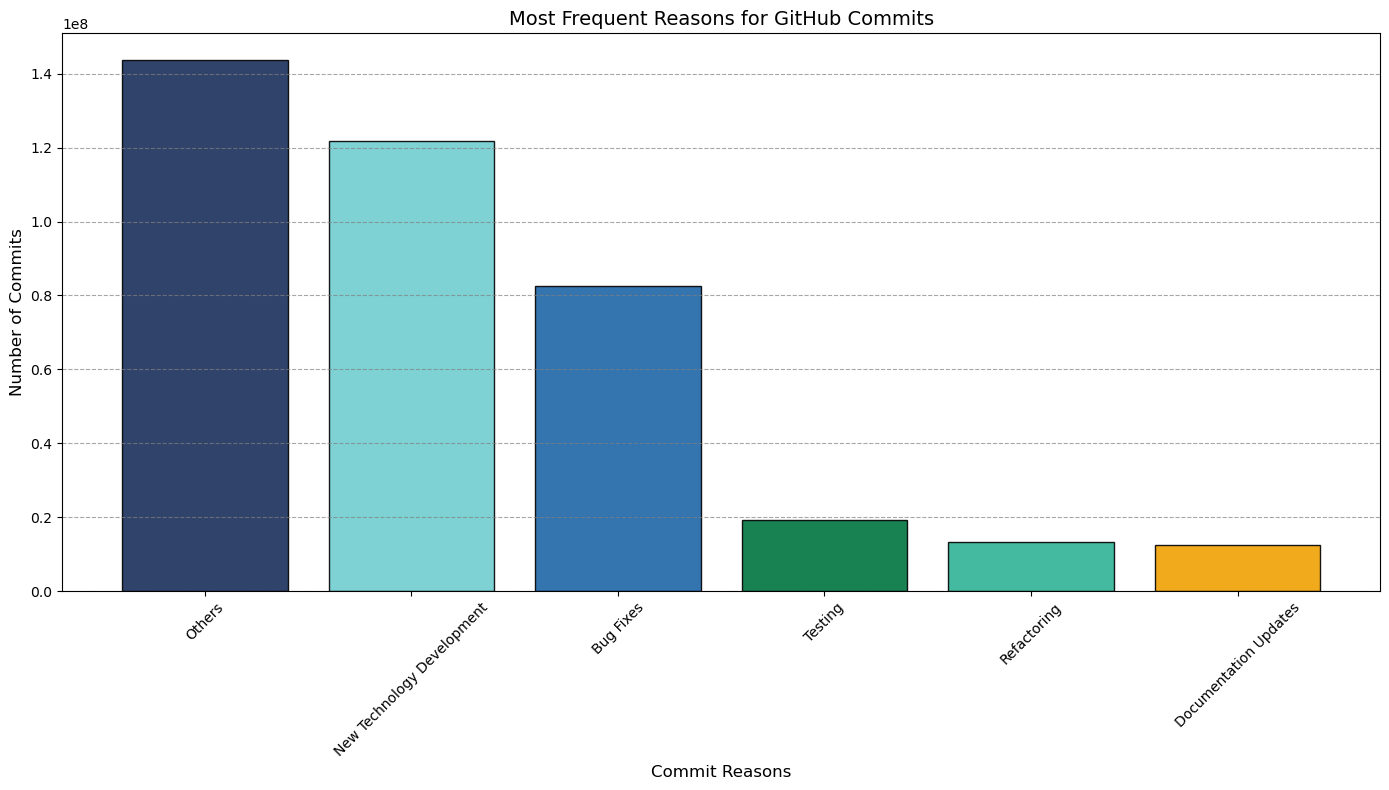

In [13]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt

# Define extended keywords for each category
categories = {
    "New Technology Development": [
        "add", "create", "develop", "initialize", "introduce", "build", "feature", "enhance", "implement", "support"
    ],
    "Bug Fixes": [
        "fix", "resolve", "bug", "patch", "repair", "debug", "issue", "hotfix", "defect", "crash"
    ],
    "Documentation Updates": [
        "doc", "readme", "documentation", "manual", "guide", "instructions", "update doc", "comment", "tutorial", "markdown"
    ],
    "Refactoring": [
        "refactor", "improve", "restructure", "clean", "simplify", "optimize", "rewrite", "modernize", "adjust", "reorganize"
    ],
    "Testing": [
        "test", "unit test", "integration test", "ci", "build", "pipeline", "automate", "verify", "mock", "benchmark"
    ],
}

# Add a new column to classify reasons for commits
def classify_reason(subject, message):
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword.lower() in (subject or "").lower() or keyword.lower() in (message or "").lower():
                return category
    return "Others"

# Register the UDF
classify_reason_udf = F.udf(classify_reason, StringType())

# Apply the classification
commits_with_reasons = commits_sampled.withColumn(
    "reason",
    classify_reason_udf(F.col("subject"), F.col("message"))
)

# Count occurrences of each category
commit_reasons = commits_with_reasons.groupBy("reason").agg(
    F.count("*").alias("count")
).orderBy(F.desc("count"))

# Convert to Pandas for visualization
commit_reasons_pandas = commit_reasons.toPandas()

# Define the color palette
grass_palette = [
    "#192E5B",  # NAVY BLUE
    "#70CED0",  # LIGHT BLUE
    "#1E65A7",  # DARK BLUE
    "#00743F",  # GREEN
    "#2FB396",  # LIGHT GREEN
    "#F1A104",  # DARK YELLOW
]

# Visualization: Bar Chart of Commit Reasons
plt.figure(figsize=(14, 8))
plt.bar(
    commit_reasons_pandas["reason"],
    commit_reasons_pandas["count"],
    color=grass_palette[: len(commit_reasons_pandas)],
    edgecolor="black",
    alpha=0.9,
)
plt.xlabel("Commit Reasons", fontsize=12, color="black")
plt.ylabel("Number of Commits", fontsize=12, color="black")
plt.title("Most Frequent Reasons for GitHub Commits", fontsize=14, color="black")
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", color="gray", alpha=0.7)
plt.tight_layout()
plt.show()


### Step 9.2: Proportion of Commit Reasons (Excluding "Others")

#### Objective:
We are visualizing the distribution of commit reasons, focusing exclusively on the following key categories:
- **New Technology Development**  
- **Bug Fixes**  
- **Testing**  
- **Refactoring**  
- **Documentation Updates**  

---

#### Approach:
1. **Filter Data**:  
   - Removing the "Others" category from the dataset to focus on the primary commit reasons.  

2. **Create Pie Chart**:  
   - Plotting a pie chart to display the proportions of each commit reason within the selected categories.  
   - Using the same color scheme as in the bar chart from Step 9.1 to maintain visual consistency.  

---

#### Insights:
This pie chart highlights the relative contribution of key commit reasons, providing a clear understanding of the primary areas of focus for developers, such as feature development, bug fixes, documentation, refactoring, and testing activities.


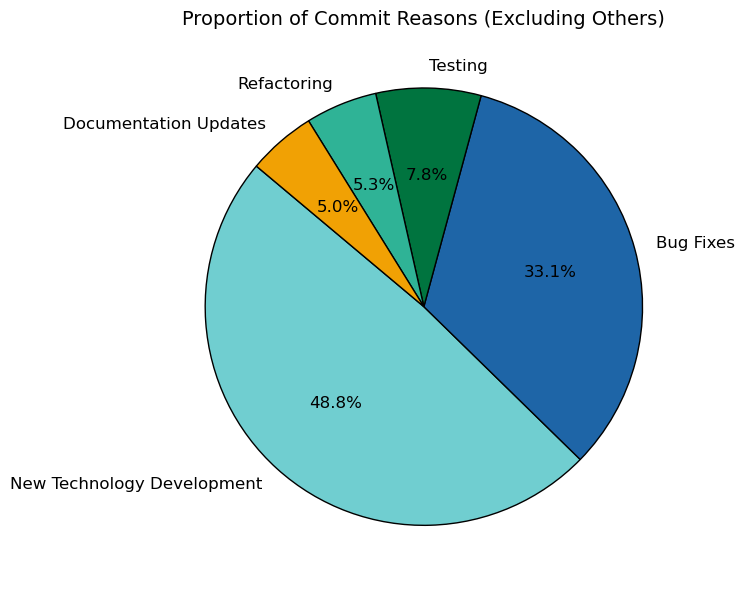

In [15]:
# Filter out the "Others" category
filtered_commit_reasons = commit_reasons_pandas[commit_reasons_pandas["reason"] != "Others"]

# Define the colors for the pie chart, corresponding to the categories
pie_colors = [
    "#70CED0",  # New Technology Development
    "#1E65A7",  # Bug Fixes
    "#00743F",  # Testing
    "#2FB396",  # Refactoring
    "#F1A104",  # Documentation Updates
]

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    filtered_commit_reasons["count"],
    labels=filtered_commit_reasons["reason"],
    colors=pie_colors,
    autopct="%1.1f%%",
    startangle=140,
    textprops={"fontsize": 12, "color": "black"},
    wedgeprops={"edgecolor": "black"},
)
plt.title("Proportion of Commit Reasons (Excluding Others)", fontsize=14, color="black")
plt.tight_layout()
plt.show()


### Step 10.1: Identifying the Most Prolific/Influential Committers

#### Objective:
We are identifying and analyzing the most prolific committers on GitHub based on their commit volumes. This step aims to visualize their contributions and the overall distribution of commits across all contributors.

---

#### Approach:

1. **Aggregate Data**:  
   - Using the `commits_sampled` dataset to count the total number of commits for each committer.  

2. **Filter Top Committers**:  
   - Identifying the top 10 committers with the highest commit volumes.  

3. **Visualization**:  
   - **Bar Graph**:  
     - Plotting the top 10 committers along with their respective commit counts.  
     - Applying distinct colors from the grass palette for better clarity and aesthetics.  
   - **Box Plot**:  
     - Displaying the distribution of commits across all contributors to analyze variability and outliers.  

---

#### Insights:
- The bar graph provides a clear view of the most active contributors and their relative contribution levels.  
- The box plot highlights the spread of contributions among committers, revealing disparities in activity levels and identifying potential outliers.  


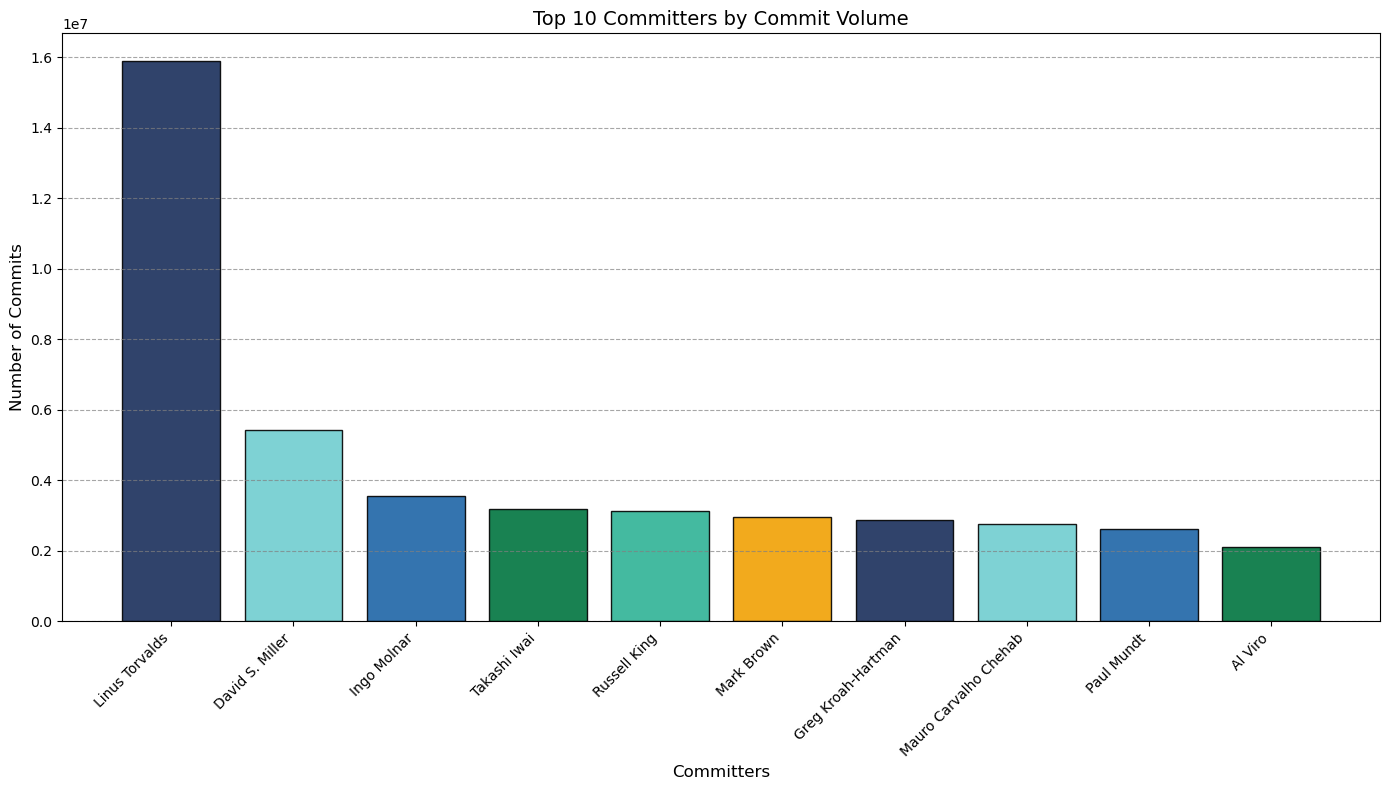

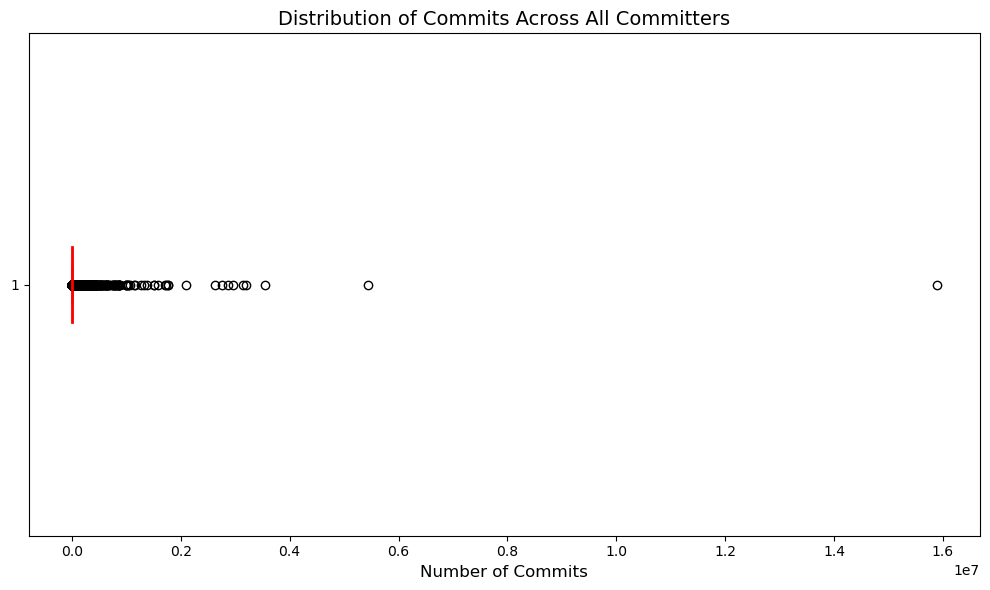

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Step 1: Aggregate data by committer name
committer_stats = commits_sampled.groupBy("committer_name").agg(
    F.count("commit").alias("commit_count")
).orderBy(F.desc("commit_count"))

# Step 2: Get the top 10 committers
top_committers = committer_stats.limit(10).toPandas()

# Step 3: Bar Graph - Top 10 Committers by Commit Volume
plt.figure(figsize=(14, 8))
plt.bar(
    top_committers["committer_name"],
    top_committers["commit_count"],
    color=grass_palette[: len(top_committers)],
    edgecolor="black",
    alpha=0.9,
)
plt.xlabel("Committers", fontsize=12, color="black")
plt.ylabel("Number of Commits", fontsize=12, color="black")
plt.title("Top 10 Committers by Commit Volume", fontsize=14, color="black")
plt.xticks(rotation=45, fontsize=10, ha="right")
plt.grid(axis="y", linestyle="--", color="gray", alpha=0.7)
plt.tight_layout()
plt.show()

# Step 4: Box Plot - Distribution of Commits Across All Committers
committer_distribution = committer_stats.toPandas()

plt.figure(figsize=(10, 6))
plt.boxplot(
    committer_distribution["commit_count"],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="#70CED0", color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    medianprops=dict(color="red", linewidth=2),
)
plt.xlabel("Number of Commits", fontsize=12, color="black")
plt.title("Distribution of Commits Across All Committers", fontsize=14, color="black")
plt.tight_layout()
plt.show()

### Step 10.2: Visualizing Top 10 Committers by Number of Commits Over Time (2008-2022)

#### Objective:
We are visualizing the activity of the top 10 committers on GitHub by analyzing their commit counts over time from 2008 to 2022.

---

#### Steps:

1. **Filter Commits by Year**:  
   - Filtering the `commits_sampled` dataset to include only commits made between 2008 and 2022.  
   - Adding a new column, `year`, by extracting the year from the `author_time_sec` field, which represents the commit timestamp.  

2. **Aggregate Commits by Committer and Year**:  
   - Grouping the filtered dataset by `committer_name` and `year`.  
   - Calculating the total number of commits for each committer in each year using the `count` function, storing the result as `total_commits`.  

3. **Filter for Top 10 Committers**:  
   - Filtering the dataset to include only the top 10 committers (stored in `top_committers`), determined by their total commit volumes.  

4. **Prepare Data for Plotting**:  
   - Converting the filtered dataset into a Pandas DataFrame for easier manipulation and visualization using Matplotlib.  

---

#### Output:
- A line chart displaying the commit activity of the top 10 committers over time (2008-2022).  
- This visualization highlights trends, peaks, and variations in the contributions of these prolific committers over the years.  


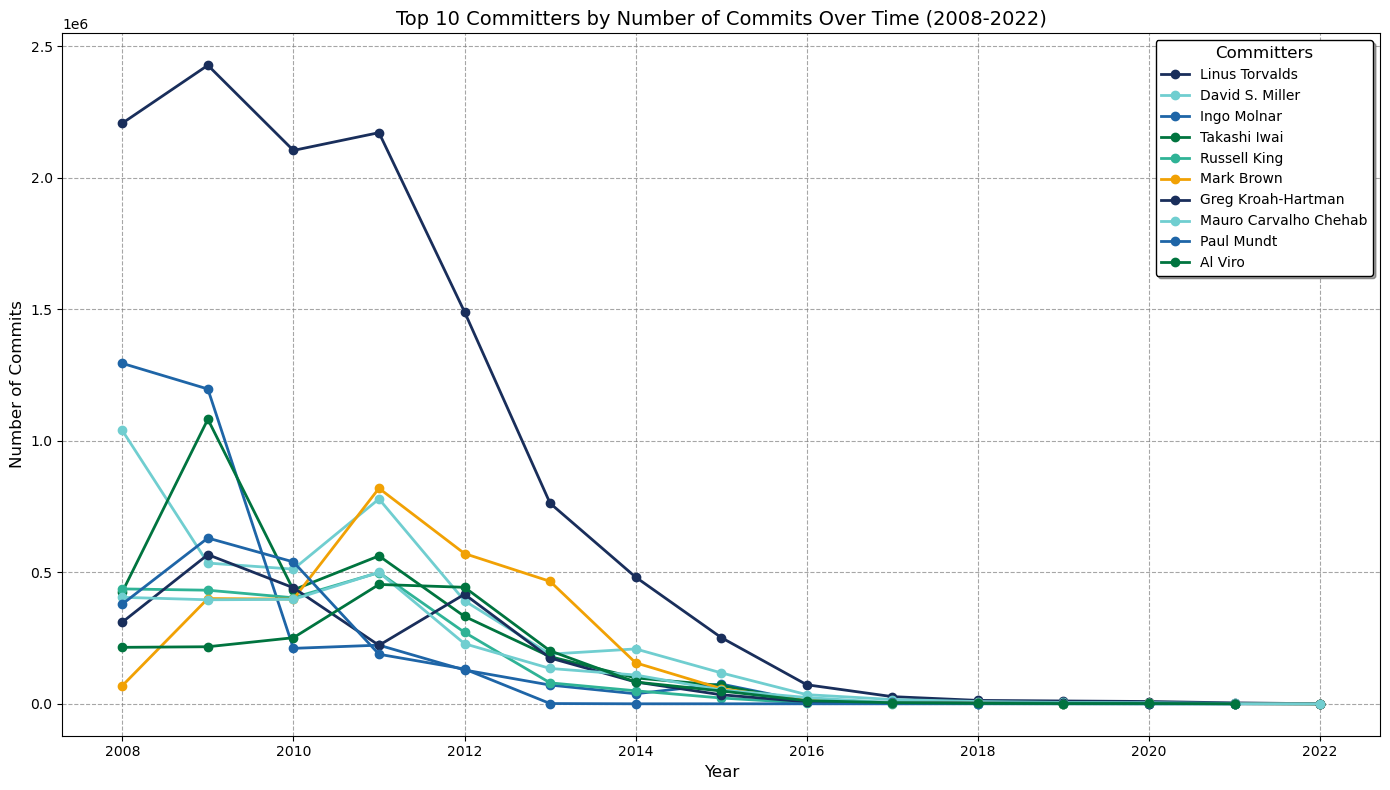

In [19]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Filter the commits_sampled dataset for the years 2008-2022
commits_with_year = commits_sampled.withColumn(
    "year", F.year(F.from_unixtime(F.col("author_time_sec")))
).filter((F.col("year") >= 2008) & (F.col("year") <= 2022))

# Get commit count by committer and year
committer_yearly_commits = commits_with_year.groupBy("committer_name", "year").agg(
    F.count("commit").alias("total_commits")
).orderBy("year", "committer_name")

# Filter for top 10 committers
top_committers_list = top_committers["committer_name"].tolist()
filtered_committer_data = committer_yearly_commits.filter(
    F.col("committer_name").isin(top_committers_list)
).toPandas()

# Define the colors for each committer, repeating if necessary
committer_colors = grass_palette * (len(top_committers_list) // len(grass_palette) + 1)

# Initialize the plot
plt.figure(figsize=(14, 8))

# Plot each committer's data
for idx, committer in enumerate(top_committers_list):
    committer_data = filtered_committer_data[
        filtered_committer_data["committer_name"] == committer
    ]
    plt.plot(
        committer_data["year"],
        committer_data["total_commits"],
        marker="o",
        label=committer,
        color=committer_colors[idx],
        linewidth=2,
    )

# Add labels, title, and legend
plt.xlabel("Year", fontsize=12, color="black")
plt.ylabel("Number of Commits", fontsize=12, color="black")
plt.title("Top 10 Committers by Number of Commits Over Time (2008-2022)", fontsize=14, color="black")
plt.legend(
    title="Committers",
    fontsize=10,
    title_fontsize=12,
    frameon=True,
    shadow=True,
    edgecolor="black",
)
plt.grid(axis="both", linestyle="--", color="gray", alpha=0.7)
plt.tight_layout()
plt.show()


### Step 11.1: Analysis of Similarity Between Subject and Message Fields in Commit Data

#### Objective:
To preprocess the `subject` and `message` fields, calculate their similarity using cosine similarity, and classify them as either "similar" or "unique" based on a defined threshold. The analysis includes visualizing the proportion of similar and unique entries.

---

#### Steps:

1. **Preprocessing Subject and Message Fields**:
   - Clean the `subject` and `message` fields by removing special characters and converting text to lowercase using `regexp_replace` and `lower` functions.
   - Drop rows with null or empty `subject` or `message` fields to ensure data quality.

2. **Tokenization**:
   - Use PySpark's `Tokenizer` to break the cleaned `subject` and `message` fields into individual tokens for further analysis.

3. **TF-IDF Transformation**:
   - Compute term frequency-inverse document frequency (TF-IDF) vectors for the tokenized `subject` and `message` fields:
     - Generate raw term frequency vectors using `HashingTF`.
     - Apply `IDF` to calculate the final TF-IDF vectors for both fields.

4. **Cosine Similarity Calculation**:
   - Convert the TF-IDF feature vectors into arrays using the `vector_to_array` function.
   - Define a UDF to calculate cosine similarity between the `subject` and `message` vectors.
   - Add a new column `cosine_similarity` to the DataFrame containing similarity scores.

5. **Classification Based on Similarity**:
   - Classify entries as "similar" or "unique" based on a cosine similarity threshold (e.g., >0.7).
   - Add a new column `similarity_class` to indicate the classification.

6. **Sampling and Visualization**:
   - Take a random sample (20%) of the classified dataset to reduce data size for visualization.
   - Group the sampled data by `similarity_class` and count the number of records in each category.
   - Create a bar chart to visualize the count of similar and unique records using distinct colors (`#1E65A7` and `#70CED0`).

---

#### Outputs:
1. **Processed DataFrame**:
   - A DataFrame containing preprocessed `subject` and `message` fields, cosine similarity scores, and similarity classifications.

2. **Visualization**:
   - Bar charts representing:
     - The count of similar and unique records based on cosine similarity.
     - Direct comparison of `subject` and `message` fields.

---

#### Insights:
- The analysis highlights the proportion of similar and unique commit messages across the dataset.
- The visualization provides a clear representation of the frequency of duplication in commit messages.


In [9]:
from pyspark.sql.functions import col, lower, regexp_replace

# Preprocess subject and message columns
preprocessed_commits_df = commits_sampled.withColumn("subject_clean", lower(regexp_replace(col("subject"), "[^a-zA-Z0-9\\s]", ""))) \
                                    .withColumn("message_clean", lower(regexp_replace(col("message"), "[^a-zA-Z0-9\\s]", "")))

# Drop rows with null or empty subject or message
preprocessed_commits_df = preprocessed_commits_df.filter((col("subject_clean").isNotNull()) & (col("subject_clean") != "")) \
                                                 .filter((col("message_clean").isNotNull()) & (col("message_clean") != ""))

In [ ]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF

# Tokenize the subject and message fields
tokenizer_subject = Tokenizer(inputCol="subject_clean", outputCol="subject_tokens")
tokenizer_message = Tokenizer(inputCol="message_clean", outputCol="message_tokens")

tokenized_df = tokenizer_message.transform(tokenizer_subject.transform(preprocessed_commits_df))

# Compute TF-IDF for subject
hashing_tf_subject = HashingTF(inputCol="subject_tokens", outputCol="subject_raw_features", numFeatures=1000)
tf_subject_df = hashing_tf_subject.transform(tokenized_df)

idf_subject = IDF(inputCol="subject_raw_features", outputCol="subject_features")
idf_subject_model = idf_subject.fit(tf_subject_df)
tfidf_subject_df = idf_subject_model.transform(tf_subject_df)

# Compute TF-IDF for message
hashing_tf_message = HashingTF(inputCol="message_tokens", outputCol="message_raw_features", numFeatures=1000)
tf_message_df = hashing_tf_message.transform(tfidf_subject_df)

idf_message = IDF(inputCol="message_raw_features", outputCol="message_features")
idf_message_model = idf_message.fit(tf_message_df)
tfidf_df = idf_message_model.transform(tf_message_df)

In [ ]:
from pyspark.ml.functions import vector_to_array

# Convert feature vectors to arrays
converted_df = tfidf_df.withColumn("subject_dense", vector_to_array(col("subject_features"))) \
                       .withColumn("message_dense", vector_to_array(col("message_features")))

In [ ]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import DoubleType
import numpy as np

# Define a UDF to calculate cosine similarity
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0
    return float(dot_product / (norm_v1 * norm_v2))

cosine_similarity_udf = udf(cosine_similarity, DoubleType())

# Apply the UDF to compute similarity
similarity_df = converted_df.withColumn(
    "cosine_similarity",
    cosine_similarity_udf(col("subject_dense"), col("message_dense"))
)

# Show the similarity results
similarity_df.select("subject_clean", "message_clean", "cosine_similarity").show(10, truncate=False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|subject_clean                                          |message_clean                                  

In [ ]:
from pyspark.sql.functions import when, col

# Add a new column 'similarity_class' based on the cosine similarity threshold
similarity_df = similarity_df.withColumn(
    "similarity_class",
    when(col("cosine_similarity") > 0.7, "similar").otherwise("unique")
)

In [ ]:
similarity_df_sampled = similarity_df.sample(fraction = 0.2, withReplacement = False, seed=42)

In [ ]:
# Count the number of similar and unique records
similarity_counts = similarity_df_sampled.groupBy("similarity_class").count().toPandas()

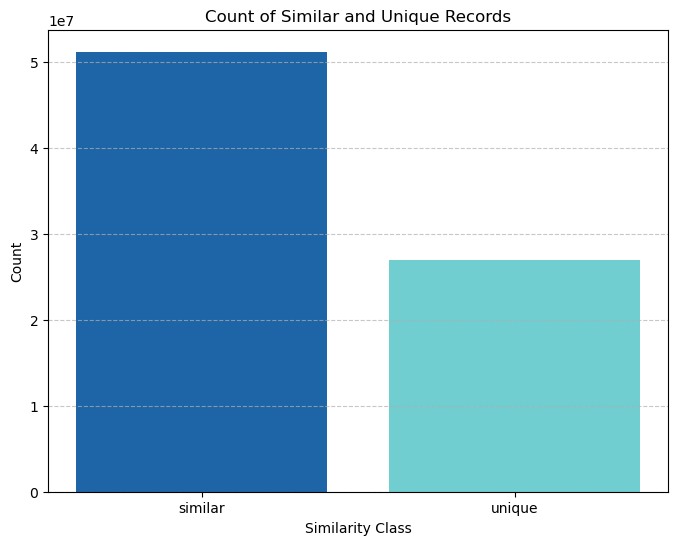

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(similarity_counts["similarity_class"], similarity_counts["count"], color=['#1E65A7', '#70CED0'])
plt.title("Count of Similar and Unique Records")
plt.xlabel("Similarity Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

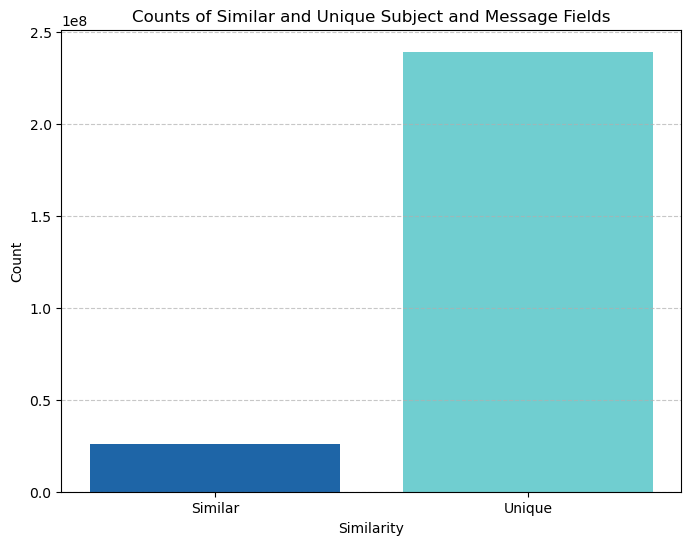

In [ ]:
from pyspark.sql.functions import when, col

# Step 1: Add a column to indicate similarity
similarity_df = commits_df.withColumn(
    "similarity",
    when(col("subject") == col("message"), "Similar").otherwise("Unique")
)

# Step 2: Group by similarity and count
similarity_counts_df = similarity_df.groupBy("similarity").count()

# Step 3: Convert to Pandas for visualization
similarity_counts_pd = similarity_counts_df.toPandas()

# Step 4: Plot bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(similarity_counts_pd["similarity"], similarity_counts_pd["count"], color=["#1E65A7", "#70CED0"])
plt.title("Counts of Similar and Unique Subject and Message Fields")
plt.xlabel("Similarity")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Step 11.2: Analyzing Similarity Between Subject and Message Across Top 10 Programming Languages

#### Objective:
To identify and analyze the similarity between commit `subject` and `message` fields across the top 10 programming languages by byte usage. The goal is to classify commits as "similar" or "unique" and visualize the distribution for each language.

---

#### Steps:

1. **Aggregate Total Bytes for Each Language**:  
   - Group the `languages_filtered` dataset by `language_name` and sum the `language_bytes` to calculate total byte usage.  
   - Sort the results in descending order to identify the top programming languages by total usage.  

2. **Filter Top 10 Programming Languages**:  
   - Extract the top 10 languages by total bytes and filter the dataset to include only repositories using these languages.  

3. **Preprocess Subject and Message Fields**:  
   - Clean the `subject` and `message` fields by removing special characters and converting them to lowercase.  
   - Drop rows with null or empty `subject` or `message` fields to ensure data quality.  

4. **Tokenize and Vectorize**:  
   - Use PySpark's `Tokenizer` to tokenize the cleaned `subject` and `message` fields into individual words.  
   - Generate raw term frequency vectors using `HashingTF` and compute TF-IDF features for both fields using `IDF`.  

5. **Calculate Cosine Similarity**:  
   - Define a custom UDF to calculate cosine similarity between the TF-IDF vectors of `subject` and `message`.  
   - Add a new column `cosine_similarity` to store the similarity scores.  

6. **Classify as Similar or Unique**:  
   - Based on a cosine similarity threshold (>0.7), classify commits as "similar" or "unique".  
   - Add a column `similarity_class` to store the classification.  

7. **Aggregate and Visualize**:  
   - Group the data by programming language and `similarity_class` to count the number of similar and unique commits for each language.  
   - Visualize the results using a bar chart with distinct colors (`#1E65A7` for similar and `#70CED0` for unique).  

---

#### Outputs:
- **DataFrame**: Contains preprocessed fields, TF-IDF features, cosine similarity scores, and similarity classifications.  
- **Visualization**: A bar chart showing the count of similar and unique commits for the top 10 programming languages.

---

#### Insights:
- This analysis provides insights into the frequency of message duplication across programming languages.  
- The visualization highlights patterns in commit message writing and potential trends in reuse across the most widely used programming languages.


In [17]:
from pyspark.sql.functions import sum

# Step 1: Aggregate total bytes for each language
language_totals_df = languages_filtered.groupBy("language_name") \
                                       .agg(sum("language_bytes").alias("total_bytes")) \
                                       .orderBy("total_bytes", ascending=False)

# Step 2: Get the top 10 languages
top_10_languages = [row["language_name"] for row in language_totals_df.limit(10).collect()]

# Display the top 10 languages
language_totals_df.show(10)


+-------------+-------------+
|language_name|  total_bytes|
+-------------+-------------+
|            C|5040981381235|
|   JavaScript|1188841011908|
|          C++| 473721400818|
|          PHP| 400784976531|
|         HTML| 321316118761|
|         Java| 288487987589|
|       Python| 177043154288|
|          CSS| 133944941484|
|           C#| 122903494858|
|     Assembly| 111070254192|
+-------------+-------------+
only showing top 10 rows



In [19]:
from pyspark.sql.functions import col 
commits_with_languages_df = commits_sampled.join(languages_filtered, "repo_name").filter(col("language_name").isin(top_10_languages))

In [20]:
from pyspark.sql.functions import col, lower, regexp_replace

# Preprocess subject and message columns
preprocessed_commits_df2 = commits_with_languages_df.withColumn("subject_clean", lower(regexp_replace(col("subject"), "[^a-zA-Z0-9\\s]", ""))) \
                                    .withColumn("message_clean", lower(regexp_replace(col("message"), "[^a-zA-Z0-9\\s]", "")))

# Drop rows with null or empty subject or message
preprocessed_commits_df2 = preprocessed_commits_df2.filter((col("subject_clean").isNotNull()) & (col("subject_clean") != "")) \
                                                 .filter((col("message_clean").isNotNull()) & (col("message_clean") != ""))

In [ ]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

# Tokenize and vectorize
tokenizer = Tokenizer(inputCol="subject_clean", outputCol="subject_tokens")
preprocessed_commits_df2 = tokenizer.transform(preprocessed_commits_df2)

tokenizer = Tokenizer(inputCol="message_clean", outputCol="message_tokens")
preprocessed_commits_df2 =a tokenizer.transform(preprocessed_commits_df2)

hashing_tf = HashingTF(inputCol="subject_tokens", outputCol="subject_raw_features")
preprocessed_commits_df2 = hashing_tf.transform(preprocessed_commits_df2)

hashing_tf = HashingTF(inputCol="message_tokens", outputCol="message_raw_features")
preprocessed_commits_df2 = hashing_tf.transform(preprocessed_commits_df2)

idf = IDF(inputCol="subject_raw_features", outputCol="subject_features")
idf_model = idf.fit(preprocessed_commits_df2)
preprocessed_commits_df2 = idf_model.transform(preprocessed_commits_df2)

idf = IDF(inputCol="message_raw_features", outputCol="message_features")
idf_model = idf.fit(preprocessed_commits_df2)
preprocessed_commits_df2 = idf_model.transform(preprocessed_commits_df2)

In [22]:
from pyspark.ml.linalg import DenseVector
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, lit, when

def cosine_similarity(vec1, vec2):
    dot_product = float(vec1.dot(vec2))
    magnitude = float(vec1.norm(2) * vec2.norm(2))
    if magnitude == 0:
        return 0.0
    return dot_product / magnitude

cosine_similarity_udf = udf(cosine_similarity, DoubleType())

preprocessed_commits_df2 = preprocessed_commits_df2.withColumn(
    "cosine_similarity",
    cosine_similarity_udf(col("subject_features"), col("message_features"))
)

# Step 4: Classify as 'similar' or 'unique'
preprocessed_commits_df2 = preprocessed_commits_df2.withColumn(
    "similarity_class",
    when(col("cosine_similarity") > 0.7, lit("similar")).otherwise(lit("unique"))
)

In [ ]:
similarity_counts = preprocessed_commits_df2.groupBy("language_name", "similarity_class") \
                                             .count() \
                                             .toPandas()

24/12/13 18:51:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.1 MiB
24/12/13 22:53:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.1 MiB


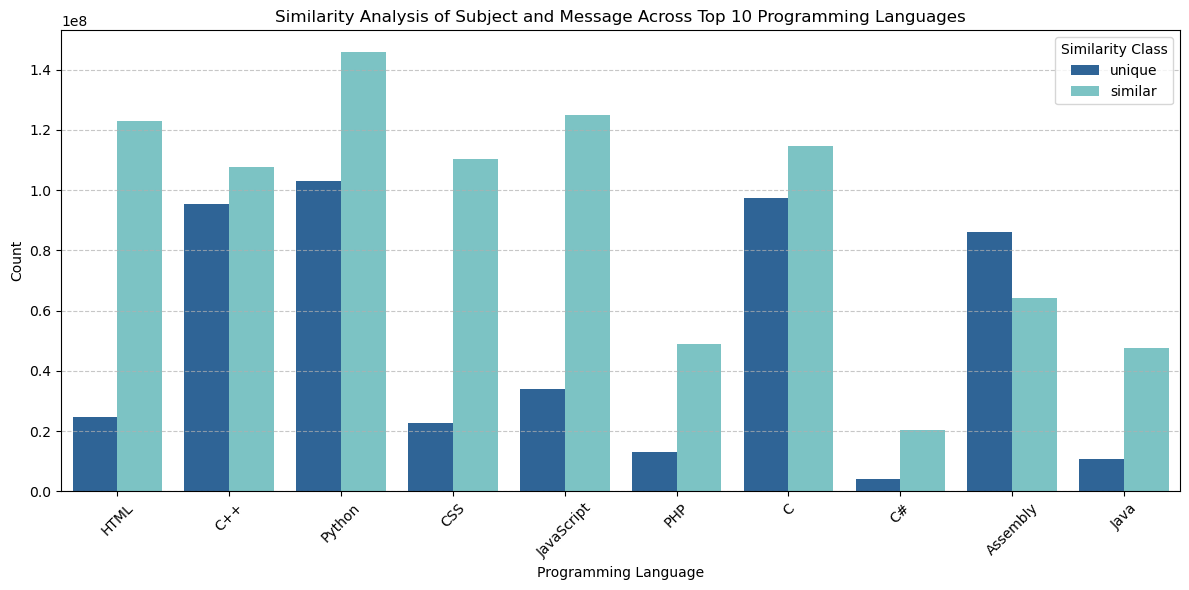

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the color palette for the bars
sns.set_palette(sns.color_palette(['#1E65A7', '#70CED0']))

plt.figure(figsize=(12, 6))
sns.barplot(data=similarity_counts, x="language_name", y="count", hue="similarity_class")
plt.title("Similarity Analysis of Subject and Message Across Top 10 Programming Languages")
plt.xlabel("Programming Language")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Similarity Class")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
